
# Image Segmentation with Deep Learning

Welcome to the **BILD 2025 Summer School** hands-on session on medical image segmentation!  
This notebook will guide you through training, evaluating, and **comparing deep learning models** for brain tumor segmentation.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/albarqounilab/BILD-Summer-School/blob/main/notebooks/day2/segmentation_solution.ipynb)
![banner](https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/helpers/notebook-banner.png)

---

## Today's Goals

By the end of this notebook, you will be able to:
- **Understand & Prepare Medical Imaging Data:** Load and process MRI scans into a deep learning pipeline.
- **Train a Segmentation Model:** Fit a U-Net baseline to identify tumor regions.
- **Master Segmentation Metrics:** Use and interpret **Dice** and **IoU** during evaluation.
- **Compare Architectures:** Benchmark losses/variants and understand trade-offs.
- **Explore Foundation Models:** Run **MedSAM** (prompt-based) and compare to U-Net.

**Objectives:** You'll see how AI can delineate structures (like your manual contouring) but faster and consistently. You'll also apply core DL skills to a high-impact real-world task.

## Dataset

We will use the [The Brain Resection Multimodal Imaging Database](https://www.cancerimagingarchive.net/collection/remind/) [1]. The Brain Resection Multimodal Imaging Database (ReMIND) contains pre- and intra-operative brain MRI collected on 114 consecutive patients who were surgically treated with image-guided tumor resection between 2018 and 2022.

[1] Juvekar, P., Dorent, R., Kögl, F., Torio, E., Barr, C., Rigolo, L., Galvin, C., Jowkar, N., Kazi, A., Haouchine, N., Cheema, H., Navab, N., Pieper, S., Wells, W. M., Bi, W. L., Golby, A., Frisken, S., & Kapur, T. (2023). The Brain Resection Multimodal Imaging Database (ReMIND) (Version 1) [dataset]. The Cancer Imaging Archive. [https://doi.org/10.7937/3RAG-D070](https://doi.org/10.7937/3RAG-D070)



## 1. Environment Setup

We install and import required libraries. Run this once per new environment.

> **Note:** The cell will install packages (internet required). If you're offline, skip installation and ensure the environment already has the packages.

### Import libraries (3 minutes)

In [1]:
# Install the required libraries for our notebook
# segmentation-models-pytorch is a great library with pre-built segmentation model architectures.
# albumentations is a powerful library for data augmentation.
!pip install -U segmentation-models-pytorch albumentations SimpleITK -q

# Library Imports
# Standard libraries
import os
import sys
import warnings
from glob import glob
import math
import time
import gc # Garbage collector to clean RAM

# Data handling and processing
import numpy as np
import pandas as pd
import cv2

# Image processing and visualization
import SimpleITK as sitk
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Deep Learning with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import segmentation_models_pytorch as smp


# Utilities
from tqdm import tqdm
# --- Environment Configuration ---
warnings.filterwarnings(action="ignore")
os.environ["PYTHONWARNINGS"] = "ignore"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This ensures that SimpleITK does not print excessive warnings.
sitk.ProcessObject.SetGlobalWarningDisplay(False)

# Setup reproducibility
import random
RANDOM_SEED   = 42
def set_seed(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(RANDOM_SEED)

print("Libraries imported and environment configured successfully!")

Libraries imported and environment configured successfully!



## 2. The Dataset: Brain Tumor MRIs (ReMIND-style)

We’ll use a **ReMIND** dataset structure with MRI volumes and tumor masks.  
If downloads fail or data aren’t present, we’ll provide a **synthetic fallback** so the notebook always runs.

### 2.1 Downloading the Data (2 minutes)
> ~1.8GB; may take a few minutes. If you're have the local data, skip.


In [ ]:
# !pip -q install -U "huggingface_hub[cli]" -q
!hf download albarqouni/bild-dataset --repo-type dataset --include "Segmentation/data.zip" --local-dir ./
!unzip -q ./Segmentation/data.zip -d ./

# If you want to download the trained model checkpoints (uncomment) | For low resource environments
!hf download albarqouni/bild-dataset --repo-type dataset --include "Segmentation/checkpoints.zip" --local-dir ./
!unzip Segmentation/checkpoints.zip -d ./

!hf download albarqouni/bild-dataset --repo-type dataset --include "Segmentation/mc_results.pkl" --local-dir ./


Fetching 1 files:   0% 0/1 [00:00<?, ?it/s]Downloading 'Segmentation/data.zip' to '.cache/huggingface/download/Segmentation/23Dbe7avWvG_zN9I64k6QY05sWY=.ee85a63e2a628a63525d549e5c714f3b34eaca1a7b452c20a82efe50f36c3758.incomplete'

data.zip:   0% 0.00/1.81G [00:00<?, ?B/s]
data.zip:   1% 10.5M/1.81G [00:00<00:24, 74.9MB/s]
data.zip:   2% 31.5M/1.81G [00:00<00:16, 110MB/s] 
data.zip:   3% 52.4M/1.81G [00:00<00:12, 140MB/s]
data.zip:   4% 73.4M/1.81G [00:00<00:11, 158MB/s]
data.zip:   5% 94.4M/1.81G [00:00<00:10, 161MB/s]
data.zip:   6% 115M/1.81G [00:00<00:10, 162MB/s] 
data.zip:   8% 136M/1.81G [00:00<00:11, 150MB/s]
data.zip:   9% 157M/1.81G [00:01<00:11, 148MB/s]
data.zip:  10% 178M/1.81G [00:01<00:12, 130MB/s]
data.zip:  11% 199M/1.81G [00:01<00:13, 116MB/s]
data.zip:  12% 220M/1.81G [00:01<00:12, 123MB/s]
data.zip:  13% 241M/1.81G [00:01<00:13, 113MB/s]
data.zip:  14% 262M/1.81G [00:02<00:14, 109MB/s]
data.zip:  16% 283M/1.81G [00:02<00:14, 109MB/s]
data.zip:  17% 304M/1.81G [00:02


Understanding the Data Structure

We expect:
```
data/ReMIND/
  sub-001/
    anat/T1w*                           # image volume (DICOM folder)
    seg/ReMIND-001-preop-SEG-tumor-*.nrrd  # binary mask
  sub-002/...
  ReMIND_metadata.csv
```


### 2.2. Data Handling Utilities

These helper functions form the backbone of our data loading pipeline. They are designed to be robust and handle the common complexities of medical imaging data formats and the crucial need for spatial alignment.

-   **`load_dicom_series_to_3d_image(path)`**: Medical scans like MRIs are often stored as a folder containing hundreds of 2D DICOM files, one for each slice. This function uses SimpleITK's powerful `ImageSeriesReader` to intelligently read all slices in a given folder and stack them into a single, coherent 3D volume.

-   **`reconstruct_mask_in_image_space(mask, reference)`**: This is arguably the most critical function for data integrity. A segmentation mask and its corresponding image might have different origins, orientations, or spacing. This function uses resampling to transform the `mask` so that it perfectly aligns with the physical coordinate system of the `reference` image. It uses **Nearest Neighbor interpolation** to ensure that the discrete mask labels (e.g., 0 for background, 1 for tumor) are preserved without creating new, intermediate values (like 0.5).

-   **`load_volume_any(path)`**: A versatile wrapper that abstracts away the file format. It checks if the provided path is a directory (and assumes it's a DICOM series) or a single file (like a NIfTI `.nii` or NRRD `.nrrd`) and uses the correct loading method. It returns the 3D image data as a NumPy array and the physical spacing of the pixels.

-   **`normalize_zero_one(array)`**: This function handles contrast normalization. Instead of a simple min-max scaling which is sensitive to extreme outliers (e.g., imaging artifacts), it uses the **1st and 99th percentiles** as the floor and ceiling. This makes the normalization more robust and typically produces better visual contrast for deep learning models.

-   **`discover_patients(path)`**: This utility acts like a web scraper for your file system. It automatically scans a data directory, looks for folders named `sub-*`, and within each, verifies the existence of both an image file (`anat/T1w*`) and a corresponding segmentation file (`seg/ReMIND*.nrrd`). It returns a list of all patient cases that have valid data pairs, which we can then use to build our dataset.

In [2]:
# Utility functions for I/O and alignment

def load_dicom_series_to_3d_image(p): return sitk.ReadImage(sitk.ImageSeriesReader().GetGDCMSeriesFileNames(p))
def reconstruct_mask_in_image_space(m, r): return sitk.Resample(m, r, sitk.Transform(), sitk.sitkNearestNeighbor, 0, m.GetPixelID())
def load_volume_any(p): return load_dicom_series_to_3d_image(p) if os.path.isdir(p) else sitk.ReadImage(p)

def normalize_zero_one(x):
    a, b = np.percentile(x, 1), np.percentile(x, 99)
    return np.clip((x - a) / (b - a + 1e-6), 0.0, 1.0)


def discover_patients(p):
    pats = []
    for sub in sorted(glob(os.path.join(p, "sub-*"))):
        idx = os.path.basename(sub).split("-")[-1]
        imgs = glob(os.path.join(sub, "anat", "T1w*"))
        segs = glob(os.path.join(sub, "seg", f"ReMIND-{idx}-preop-SEG-tumor-*.nrrd"))
        if imgs and segs: pats.append({'id': idx, 'img_path': imgs[0], 'seg_path': segs[0]})
    return pats



### 2.3 Load Clinical Metadata & Clean

Real-world datasets are rarely perfect. We begin by loading the clinical metadata CSV file, which contains information about each patient case, such as the tumor's `Histopathology`. We then perform two key cleaning steps to ensure our dataset is robust and well-behaved for training a machine learning model.

In [3]:
DATA_PATH = "data/ReMIND"
clinical_df = pd.read_csv(f"{DATA_PATH}/ReMIND_metadata.csv")
clinical_df

,Case Number,Age,Sex,Race,Ethnicity,Laterality,Previous Craniotomy,WHO Grade,Histopathology
0,1,41,Male,White,Not Hispanic,Right,No,3,Astrocytoma
1,2,22,Female,White,Not Hispanic,Right,No,2,Astrocytoma
2,3,30,Male,Asian,Not Hispanic,Left,No,2,Oligodendroglioma
3,4,23,Male,White,Hispanic,Left,No,1,Dysembryoplastic neuroepithelial tumor
4,5,27,Male,White,Not Hispanic,Right,No,Not assigned,Non-tumor epileptogenic brain parenchyma and g...
...,...,...,...,...,...,...,...,...,...
109,110,47,Male,White,Not Hispanic,Right,No,2,Oligodendroglioma
110,111,42,Female,White,Not Hispanic,Left,No,3,Astrocytoma
111,112,40,Female,Asian,Not Hispanic,Right,Yes,4,Astrocytoma
112,113,50,Female,White,Not Hispanic,Right,Yes,4,Glioblastoma


In [4]:
# First, let's inspect the distribution of tumor types
print("Original Histopathology Distribution:\n")
print(clinical_df["Histopathology"].value_counts())

Original Histopathology Distribution:

Histopathology
Astrocytoma                                                                                                                                                                               33
Glioblastoma                                                                                                                                                                              31
Oligodendroglioma                                                                                                                                                                         24
Dysembryoplastic neuroepithelial tumor                                                                                                                                                     2
Metastatic Carcinoma from Lung Adenocarcinoma                                                                                                                                              2
N

In [5]:
# Data Cleaning Step 1: Group Rare Classes
hist_counts = clinical_df["Histopathology"].value_counts()
# Identify all tumor types that appear 2 or fewer times
to_other = hist_counts[hist_counts <= 2].index
clinical_df["Histopathology"] = clinical_df["Histopathology"].replace(to_other, "Other")
print("\nCleaned Histopathology Distribution:\n")
print(clinical_df["Histopathology"].value_counts())


Cleaned Histopathology Distribution:

Histopathology
Astrocytoma          33
Glioblastoma         31
Other                26
Oligodendroglioma    24
Name: count, dtype: int64


#### Why do we group infrequent histopathology types into 'Other'?

When we first inspect the distribution of tumor types using `value_counts()`, we can see that some categories, like "Atypical Meningioma" or "Metastatic carcinoma", may have only one or two examples in the entire dataset. This severe class imbalance poses several significant problems for training a reliable machine learning model:

1.  **Impossible Stratification**: When we split our data into training, validation, and test sets, we use stratification to ensure each set has a similar distribution of classes. If a class has only one sample, it's impossible to distribute it across all three sets. This can lead to sets where certain tumor types are completely absent, making it impossible to train or evaluate the model's performance on them.

2.  **Inability to Learn Generalizable Patterns**: A deep learning model cannot learn the general visual characteristics of a "Metastasis" tumor from a single example. Instead of learning what makes a metastasis look like a metastasis, it will simply memorize the specific features of that one unique image.

3.  **Risk of Overfitting**: The model will likely overfit to the few examples of rare classes it sees, leading to poor performance when it encounters a new, unseen example of that same class in the real world.

By grouping these extremely rare instances into a single, more substantial **'Other'** category, we create a more balanced and statistically stable dataset. This pragmatic step ensures that our data splits are meaningful and that the model can learn from groups that are large enough to contain generalizable patterns. It is a common and necessary practice in applied machine learning to handle the long-tail distributions often found in real-world data.

#### Data Cleaning Step: Exclude Problematic Cases

Before training any model, it is crucial to perform **visual quality control** on the dataset. While automated scripts can load and process thousands of images, they cannot replace the expert human eye in identifying subtle yet critical issues.

**"Garbage In, Garbage Out"**: This is a fundamental principle in machine learning. If we train our model on poor-quality or incorrectly labeled data, it will learn incorrect patterns, and its predictions will be unreliable.

In [6]:
#@title Plot patients
def plot_n_patients(clinical_df, n=5):
    plotted = 0
    for _, row in clinical_df.iterrows():
        if plotted >= n:
            break

        patient   = row['Case Number']
        hist_type = row['Histopathology']
        idx = str(patient).zfill(3)
        img_dir  = glob(f"{DATA_PATH}/sub-{idx}/anat/T1w*")
        seg_path = glob(f"{DATA_PATH}/sub-{idx}/seg/ReMIND-{idx}-preop-SEG-tumor-*.nrrd")

        if not img_dir or not seg_path:
            print(f"Data not found for patient {idx}. Skipping.")
            continue

        img_sitk = load_dicom_series_to_3d_image(img_dir[0])
        img_np   = sitk.GetArrayFromImage(img_sitk)

        mask_sitk = sitk.ReadImage(seg_path[0])
        mask_sitk = reconstruct_mask_in_image_space(mask_sitk, img_sitk)
        mask_np   = sitk.GetArrayFromImage(mask_sitk).astype(np.uint8)

        slices_with_tumor = [i for i, mask_slice in enumerate(mask_np) if mask_slice.any()]
        if not slices_with_tumor:
            print(f"No tumor slices found for patient {idx}. Skipping.")
            continue

        slice_to_plot_idx = slices_with_tumor[len(slices_with_tumor) // 2]
        img_slice  = img_np[slice_to_plot_idx].astype(np.float32)
        mask_slice = mask_np[slice_to_plot_idx]

        plot_img_t  = A.Compose([A.Resize(512, 512, interpolation=0), A.Normalize(0.0, 1.0), ToTensorV2()])(image=img_slice)["image"].float()
        plot_mask_t = A.Compose([A.Resize(512, 512, interpolation=0), ToTensorV2(transpose_mask=True)])(image=img_slice, mask=mask_slice)["mask"]

        img_arr  = plot_img_t.squeeze(0).numpy()
        mask_arr = plot_mask_t.squeeze().numpy()

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(img_arr, cmap="gray"); ax[0].set_title(f"{hist_type} - Patient {idx} - Original Image"); ax[0].axis("off")
        ax[1].imshow(mask_arr, cmap="gray"); ax[1].set_title(f"{hist_type} - Patient {idx} - Mask"); ax[1].axis("off")
        ax[2].imshow(img_arr, cmap="gray")
        ax[2].imshow(np.ma.masked_where(mask_arr != 1, mask_arr), cmap="Reds", alpha=0.6, vmin=0, vmax=1)
        ax[2].contour(mask_arr, levels=[0.5], colors="red", linewidths=1)
        ax[2].set_title(f"{hist_type} - Patient {idx} - Overlay"); ax[2].axis("off")
        plt.tight_layout(); plt.show()

        plotted += 1

Plotting all examples with tumors:


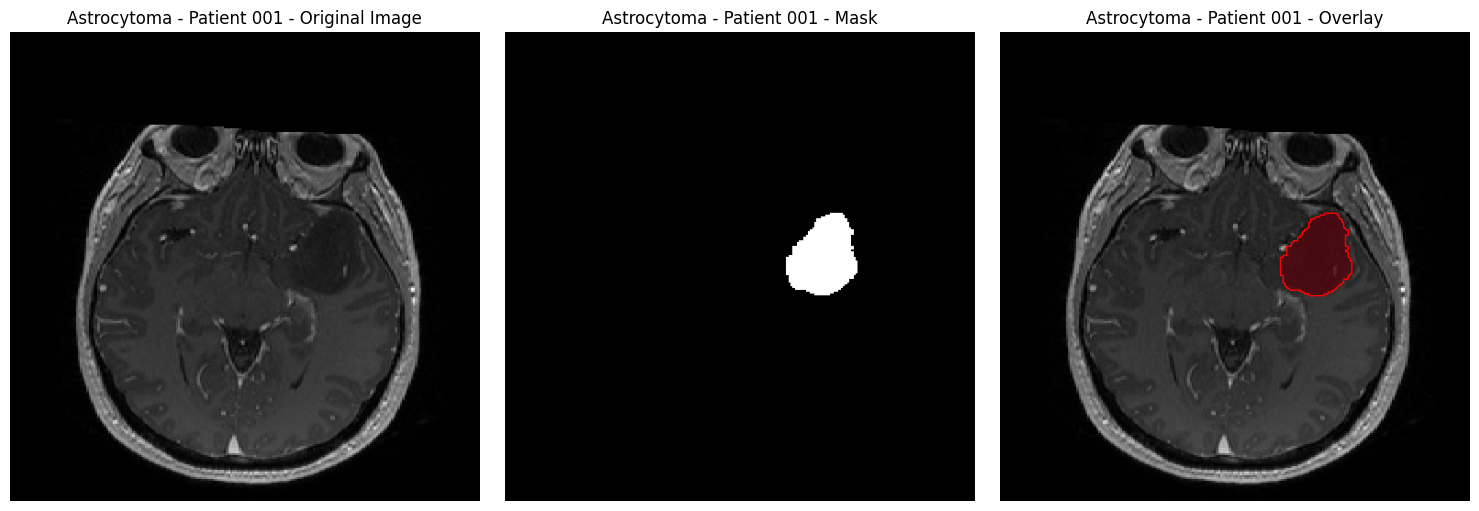

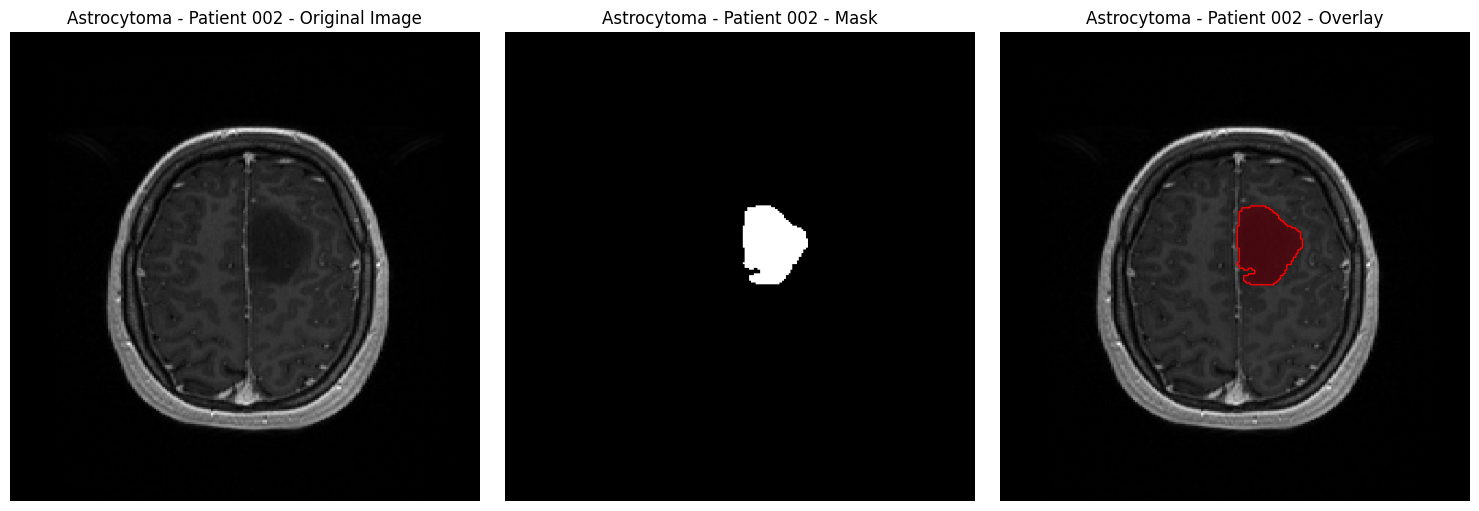

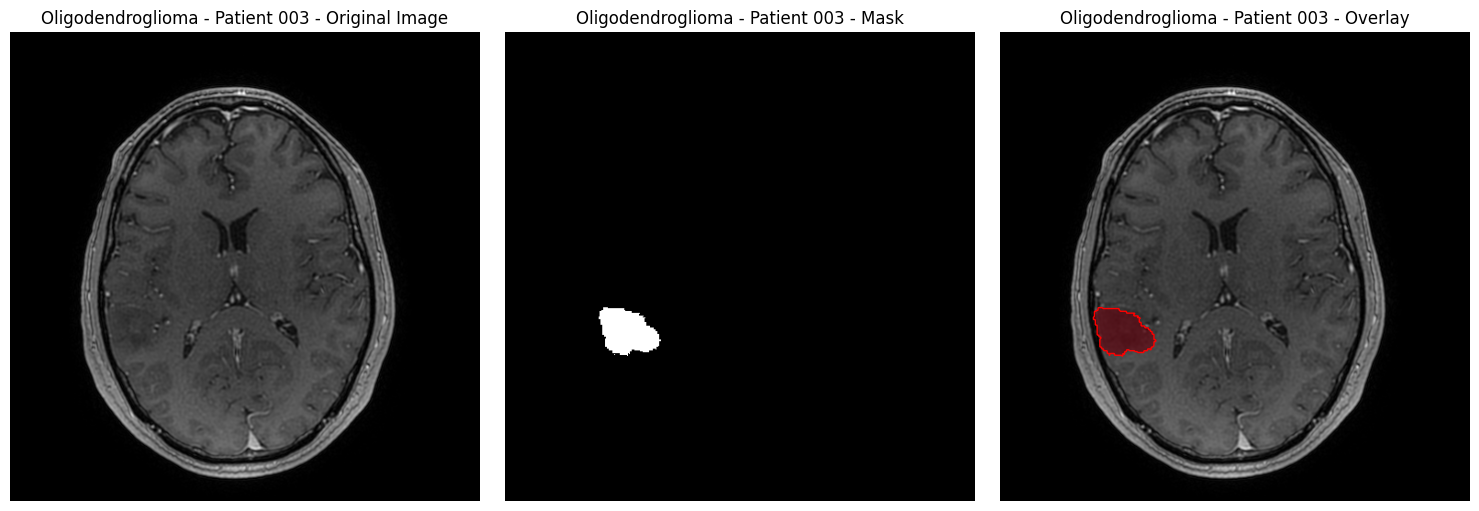

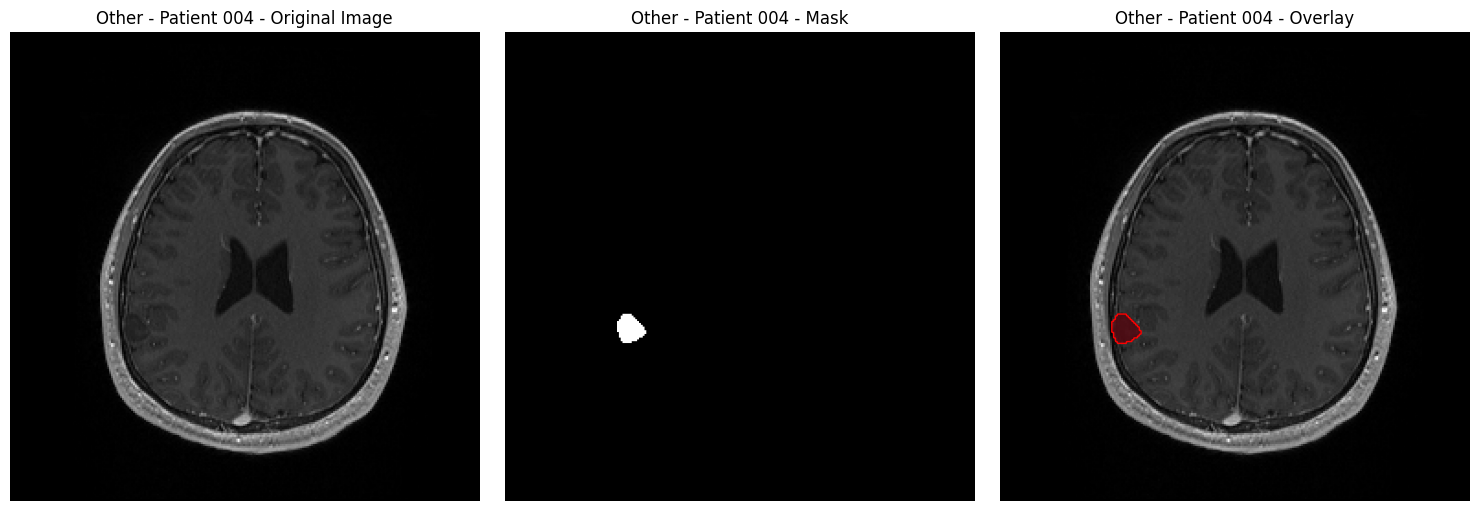

Data not found for patient 005. Skipping.


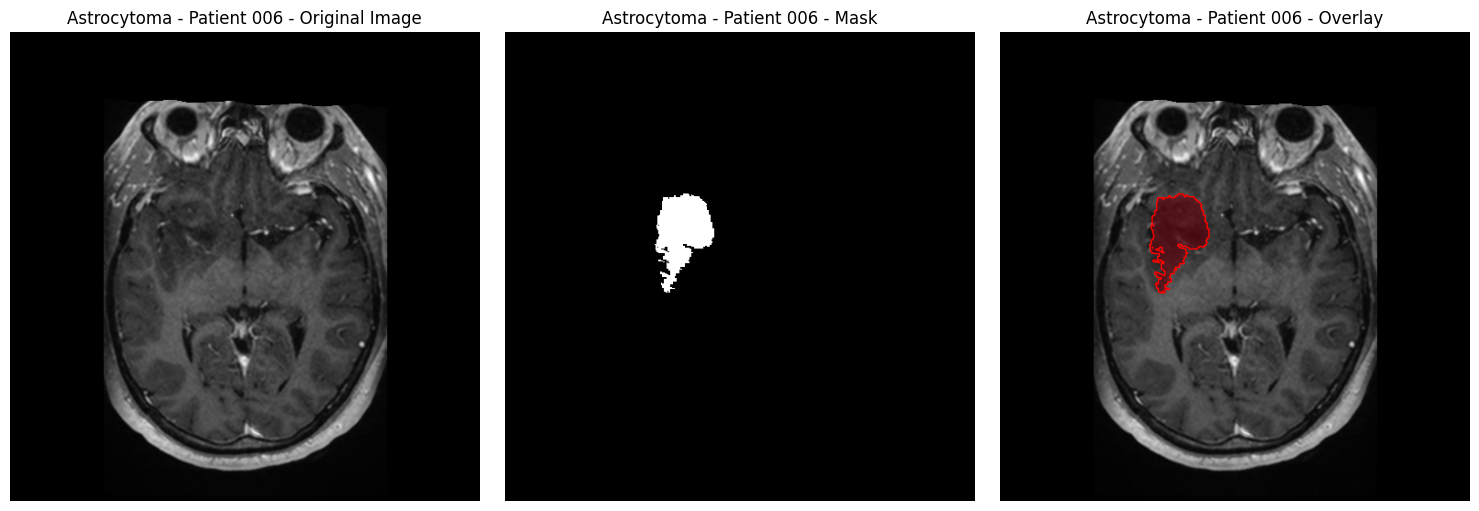

In [7]:
print("Plotting all examples with tumors:")
number_patients=5 #@param {type: "number"}
plot_n_patients(clinical_df, n=number_patients)


Here we will predefined list `excluded_patients` is used to remove specific cases from our dataset. This list is not arbitrary; it is the result of a careful, manual review process where a domain expert (like a radiologist or medical imaging scientist) inspected the data and identified cases with problems such as:

-   **Severe Imaging Artifacts**: Issues like motion artifacts, signal dropout, or aliasing can corrupt the image, making it impossible for a model (or even a human) to make a confident assessment.
-   **Incorrect or Ambiguous Annotations**: The ground truth segmentation mask might be misaligned, inaccurate, or the boundary of the pathology might be inherently ambiguous.
-   **Atypical Anatomy or Co-occurring Pathologies**: Sometimes a case might be an extreme outlier that would confuse the model more than it would help it learn a general pattern.

By explicitly removing these known problematic cases, we improve the overall quality of our training data. This leads to a more robust model that learns from clean, representative examples, ultimately resulting in better and more trustworthy performance on new, unseen data. This curation step is a hallmark of high-quality, professional machine learning projects, especially in high-stakes fields like medicine.

```
excluded_patients = [7, 16, 4, ..., 114]
```

In [9]:
excluded_patients = [7, 16, 4, 19, 22, 23, 27, 35, 41, 43, 47, 60, 76, 92, 95, 114]
clinical_df = clinical_df[~clinical_df["Case Number"].isin(excluded_patients)].reset_index(drop=True)
print(f"Clinical metadata loaded and cleaned. Final patient count: {len(clinical_df)}")

NameError: name 'clinical_df' is not defined

<div class="alert alert-block alert-danger">
<b>A Critical Note on Data Exclusion:</b>
The exclusion of patient data is a significant decision that must be handled with extreme care, especially in clinical applications. The rationale for removing any case should be transparent and based on well-defined clinical or technical criteria (e.g., severe imaging artifacts, confirmed annotation errors).

Warning: Modifying the dataset by excluding samples directly impacts the integrity of your results. Excluded data must never be used in the final test set. Furthermore, altering the standard public dataset can make direct comparisons to state-of-the-art benchmarks invalid. Always document and justify any exclusions thoroughly.
</div>


### 2.4 The `SegmentationDataset` Class

This class is the heart of our data pipeline, acting as the crucial bridge between the raw medical imaging files on our disk and the structured format PyTorch requires for training.

Think of this class as a meticulous digital assistant. Its main job is to go through every patient's 3D MRI scan, find every single 2D slice that contains a piece of the tumor, and prepare it for the model to learn from. This ensures we focus only on the relevant information.

This class inherits from PyTorch's `torch.utils.data.Dataset`. Its key responsibilities are:
1.  **In `__init__`**: It scans the data directory, indexes all valid tumor slices across all specified patients, and sets up our data augmentation pipeline using the powerful [Albumentations](https://albumentations.ai/docs/) library.
2.  **In `__getitem__`**: It retrieves a single image-mask pair by its index and applies the necessary transformations (like resizing, flipping, and converting to a tensor) on the fly.



> Data Augmentation with Albumentations: We use the albumentations library because it is incredibly fast and can transform both an image and its corresponding mask simultaneously, ensuring that geometric changes (like rotations or flips) are applied identically to both. This is crucial for segmentation tasks.

> In a nutshell: The Dataset class is a flexible blueprint for telling PyTorch how to access and prepare each individual piece of your data.




In [10]:
class SegmentationDataset(Dataset):
    def __init__(self, patient_df: pd.DataFrame, data_path: str, size: int = 512, augment: bool = True):
        self.data_path, self.size, self.slices = data_path, size, []
        self.transform = A.Compose([
            A.Resize(size, size, interpolation=1),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.6),
            A.Normalize(mean=0.0, std=1.0), ToTensorV2(),
        ]) if augment else A.Compose([
            A.Resize(size, size, interpolation=1), A.Normalize(mean=0.0, std=1.0), ToTensorV2(),
        ])
        start_time = time.time()
        patients = discover_patients(data_path)
        valid_ids = set(patient_df["Case Number"].astype(str).str.zfill(3))
        patients_to_process = [p for p in patients if p['id'] in valid_ids]
        # print("Filtered patients without available mask:",len(clinical_df) - len(patients_to_process))
        print(f"Indexing {len(patients_to_process)} patients...")
        for pat in tqdm(patients_to_process, desc="Processing Patients"):
          ref_img = load_volume_any(pat['img_path'])
          mask = sitk.ReadImage(pat['seg_path'])
          mask_resampled = reconstruct_mask_in_image_space(mask, ref_img)
          img_np = normalize_zero_one(sitk.GetArrayFromImage(ref_img).astype(np.float32))
          mask_np = sitk.GetArrayFromImage(mask_resampled).astype(np.uint8)
          for k in range(img_np.shape[0]):
              if mask_np[k].any(): self.slices.append((img_np[k], mask_np[k]))
        print(f"\nDataset ready in {time.time() - start_time:.2f}s.")

    def __len__(self): return len(self.slices)
    def __getitem__(self, idx):
        img, msk = self.slices[idx]; t=self.transform(image=img, mask=msk); return t["image"], t["mask"].unsqueeze(0).float()


> 15 minutes in



In [11]:
seg_dataset = SegmentationDataset(clinical_df, DATA_PATH, augment=True)
print("\nTotal tumor slices indexed:", len(seg_dataset))

NameError: name 'clinical_df' is not defined

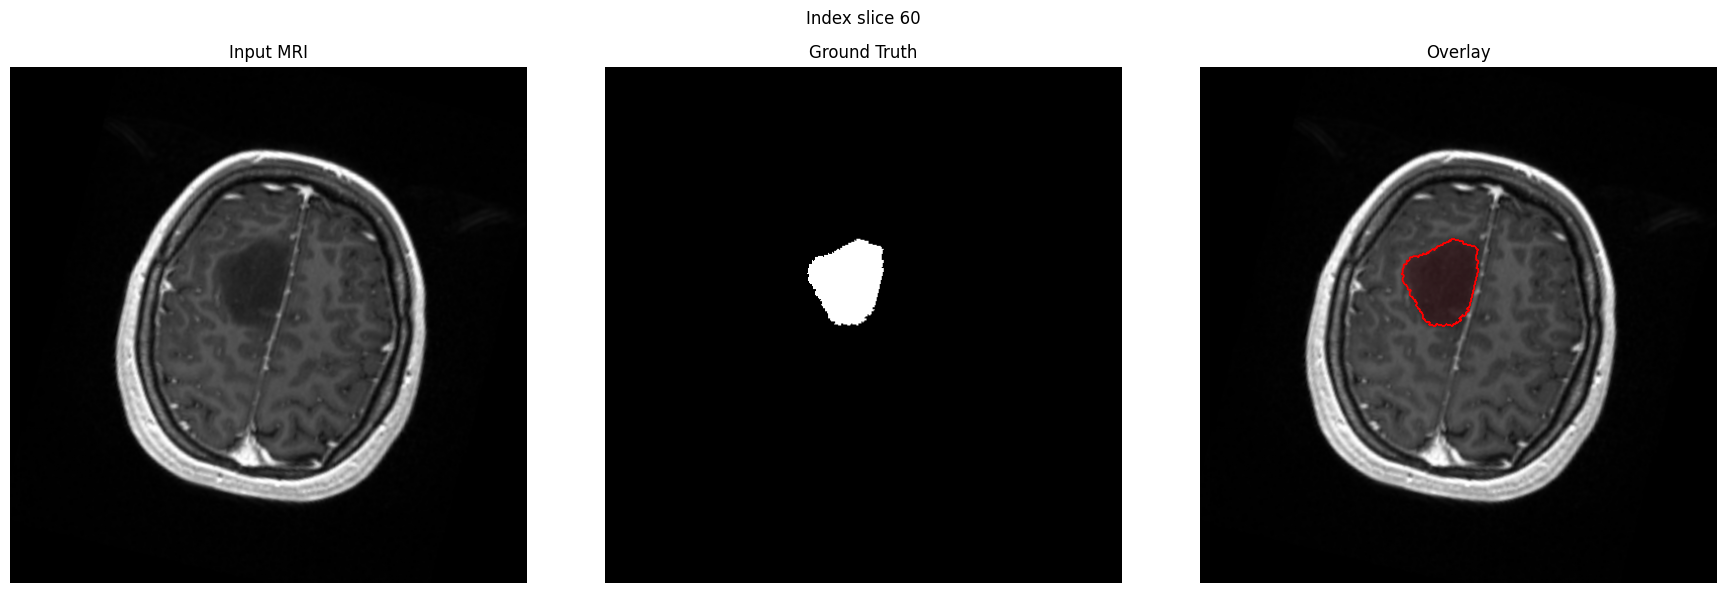

In [ ]:
#@title Sanity Check: visualize index slices form our dataset
slice_index = 60  #@param {type: "number"}

if len(seg_dataset) > 0:
    img_t, msk_t = seg_dataset[min(slice_index,len(seg_dataset)-1)]
    img_np, msk_np = img_t.squeeze().numpy(), msk_t.squeeze().numpy()
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
    fig.suptitle(f"Index slice {slice_index}\n")
    # Input MRI
    ax1.imshow(img_np,cmap="gray"); ax1.set_title("Input MRI"); ax1.axis("off")
    # Ground Truth
    ax2.imshow(msk_np,cmap="gray"); ax2.set_title("Ground Truth"); ax2.axis("off")
    # Overlay
    ax3.imshow(img_np,cmap="gray");ax3.contour(msk_np, colors="red", linewidths=0.5);
    ax3.imshow(np.ma.masked_where(msk_np != 1, msk_np),cmap="Reds", alpha=0.2, vmin=0, vmax=1)
    ax3.set_title("Overlay"); ax3.axis("off"); plt.tight_layout(); plt.show()

In [ ]:
#@title Free up system RAM so we can continue with the rest of the notebook
try:
  del seg_dataset
  gc.collect()
  print("SegmentationDataset variable deleted and garbage collection performed.")
except:
  print("Already cleaned")

Already cleaned



## 3. Data Splitting & Preparation

To build a model that we can trust, we must evaluate it on data it has never seen before. It's like teaching a student: you wouldn't test them on the exact same questions they studied in their textbook. This principle of separating learning data from testing data is fundamental to all of machine learning.

We will divide our dataset into three distinct, independent sets:

1.  **Training Set (70% of patients)**: This is the bulk of our data, our "textbook." The model will learn exclusively from these images to identify the patterns and features associated with brain tumors.
2.  **Validation Set (10% of patients)**: This is our "practice exam." During the training process, we use this set to check the model's performance on unseen data. It helps us answer crucial questions like, "Is the model starting to overfit (memorize) the training data?" and allows us to tune our model's settings (hyperparameters).
3.  **Test Set (20% of patients)**: This is the "final, proctored exam." This set is kept completely separate and is used only *once* at the very end of our project to get a final, unbiased measure of the model's performance in a real-world scenario.

---

#### The Golden Rule in Medical AI: Split by Patient

How we perform this split is critically important. Instead of randomly splitting all our 2D slices, we must split by **patient**.

Slices from the same patient are highly correlated—they share the same unique anatomy, are from the same scanner, and may have similar imaging artifacts. If we were to put some slices from Patient A into the training set and others into the test set, the model might learn to recognize Patient A's specific anatomy rather than the general features of a tumor. This critical error, known as **data leakage**, would lead to an artificially inflated performance score. The model would seem to perform well because it's "cheating" by recognizing patients it has already seen. By splitting at the patient level, we ensure our model is truly tested on its ability to generalize to new, unseen individuals.

#### The Refinement: Stratification

To make our splits even more robust, we use **stratification**. Imagine if, by pure random chance, all patients with a "Meningioma" tumor ended up in our test set. Our model would never have learned to identify them during training, leading to a guaranteed failure. Stratification prevents this by ensuring that the proportion of each tumor type (`Histopathology`) is roughly the same across the training, validation, and test sets.

In [ ]:
# Stratified patient-wise split (if metadata exists), else random
from sklearn.model_selection import train_test_split

patient_data = (clinical_df[["Case Number","Histopathology"]]
                .drop_duplicates()
                .set_index("Case Number"))
patient_list = patient_data.index.to_numpy()
patient_labels = patient_data["Histopathology"].to_numpy()
print(f"Total patients: {len(patient_list)}")
print(f"Total labels: {len(patient_labels)}")

Total patients: 98
Total labels: 98


Now we have a unique list of patients and their corresponding labels for stratification. Let's perform the split

In [ ]:
pt_train, pt_temp, lb_train, lb_temp = train_test_split(
    patient_list, patient_labels, test_size=0.3, stratify=patient_labels, random_state=RANDOM_SEED
)
pt_val, pt_test, _, _ = train_test_split(
    pt_temp, lb_temp, test_size=(2/3.0), stratify=lb_temp, random_state=RANDOM_SEED
)

train_df = clinical_df[clinical_df["Case Number"].isin(pt_train)]
val_df   = clinical_df[clinical_df["Case Number"].isin(pt_val)]
test_df  = clinical_df[clinical_df["Case Number"].isin(pt_test)]

print("Split sizes (patients if available):")
if "Case Number" in clinical_df and len(clinical_df)>0:
    print("Train:", len(pt_train), " Val:", len(pt_val), " Test:", len(pt_test))


Split sizes (patients if available):
Train: 68  Val: 10  Test: 20



#### The Final Step: The `DataLoader` (2 minutes)

Once we have our lists of patients for each set, we create `DataLoader` objects. A `DataLoader` is a powerful PyTorch utility that acts as an efficient pipeline, feeding data to the GPU. It automatically handles:
-   **Batching**: Grouping multiple images together to be processed at once.
-   **Shuffling**: Randomizing the order of the training data each epoch to improve learning.
-   **Parallelization**: Using multiple CPU cores to prepare the next batch of data while the GPU is busy, preventing bottlenecks.

In [ ]:
# Build datasets/loaders
BATCH_SIZE = 8
NUM_WORKERS = 2

train_ds = SegmentationDataset(train_df, DATA_PATH, size=512, augment=True)
val_ds   = SegmentationDataset(val_df,   DATA_PATH, size=512, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"DataLoaders ready. Train: {len(train_ds)}, Validation: {len(val_ds)}")

Filtered patients without available mask: 37
Indexing 61 patients...


Processing Patients: 100%|██████████| 61/61 [01:00<00:00,  1.00it/s]



Dataset ready in 61.07s.
Filtered patients without available mask: 88
Indexing 10 patients...


Processing Patients: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Dataset ready in 16.40s.
DataLoaders ready. Train: 2569, Validation: 392



> **Summary**:
>
> **What is Data Leakage?** Data leakage occurs when information from outside the training set is used to create the model. In medical imaging, this is a particularly insidious problem. Slices from the same patient are highly correlated; they share the same anatomy, are scanned on the same machine (with the same potential artifacts), and have the same underlying pathology.
>
> **Why is it so bad?** If you randomly split slices (instead of patients), you might have slice #5 of Patient-A in your training set and slice #10 of Patient-A in your test set. The model might learn to recognize features unique to Patient-A's anatomy or scan quality, rather than the general features of the tumor. This leads to an artificially high score on your test set because the model is effectively "cheating" by recognizing the patients it has already seen. When deployed in the real world on a new patient, its performance would be drastically lower.
>
> **The Rule:** Always split by the independent unit of interest, which in clinical applications is almost always the **patient**.
>
> **In a nutshell:** Splitting by patient ensures your model is evaluated on its ability to analyze new patients, not its ability to remember patients it saw during training.

> 25 minutes in


## 4. Modeling and Training: Teaching the AI to See

With our data meticulously prepared and loaded, we have arrived at the core of our project: building and training the neural network. This is where the learning happens. We will teach our model to distinguish between tumor and non-tumor tissue by showing it thousands of labeled examples from our training set.

Our chosen architecture is the **U-Net**, a model renowned for its success in biomedical image segmentation. We will enhance it further by using a **pre-trained encoder**, a powerful technique known as **transfer learning**.

---
> ### Deep Dive: The U-Net Architecture and Transfer Learning
>
> The **U-Net**, introduced in 2015 for biomedical image segmentation, is an elegant and powerful convolutional neural network (CNN) architecture. Its name comes from its distinctive U-shape. To understand its power, let's break it down into its three key components:
>
><img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="70%">
>
>Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab, N., Hornegger, J., Wells, W., Frangi, A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015 https://arxiv.org/pdf/1505.04597
>
> 1.  **The Encoder (or Contracting Path):** This is a standard CNN that progressively downsamples the input image. With each downsampling step (typically a max-pooling operation), the network's spatial resolution decreases, but its "semantic" understanding of the image increases. It learns to identify *what* is in the image at a high level (e.g., "there is tumor-like texture in this quadrant"). Think of it as zooming out to get the general context.
>
> 2.  **The Decoder (or Expansive Path):** This path takes the low-resolution, high-context feature map from the encoder and progressively upsamples it. Its job is to recover the spatial information and precisely localize the features identified by the encoder. It answers the question of *where* exactly the features are, ultimately creating the detailed, pixel-by-pixel segmentation mask. Think of it as zooming back in to carefully draw the outlines.
>
> 3.  **Skip Connections:** This is the U-Net's most critical innovation. Skip connections create a direct link, a "shortcut," between the encoder and decoder at the same spatial level. This allows the decoder to access the high-resolution feature maps from the early layers of the encoder. Why is this so important? The encoder, in its quest for context, loses fine-grained spatial detail. The skip connections allow the decoder to "remember" these details (like precise edges), enabling it to produce much sharper and more accurate segmentations.
>
> **The Power of Transfer Learning**: When we instantiate our U-Net, we set `encoder_weights="imagenet"`. This means the encoder part of our U-Net isn't initialized with random numbers. Instead, it's pre-loaded with knowledge learned from training on the **ImageNet** dataset—a massive collection of over a million everyday photographs. While MRIs are very different from photos, this pre-training has taught the encoder to recognize fundamental visual patterns like edges, gradients, textures, and shapes. This gives our model a significant head start, leading to faster training and often better final performance, which is especially valuable when working with smaller medical datasets.
>
> **In a nutshell:** The U-Net combines a "what" pathway (encoder) with a "where" pathway (decoder), using skip connections to preserve detail. Transfer learning gives it a head start by pre-loading it with basic visual knowledge.

In [ ]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
).to(device)

print(model.__class__.__name__, "ready on", device)

Unet ready on cuda


### Guiding the Learning: Loss Functions vs. Metrics



-   **Metric**: This is the "final grade" on a report card. It's a human-interpretable score, like the **Dice Coefficient**, that we use to judge the model's performance. It doesn't need to be differentiable and is not used for training, only for evaluation.

### The Training Loop: The Engine Room

The code that follows will define our training and validation loops. This process is orchestrated by a few key components:
-   **Optimizer (`AdamW`)**: The engine that implements the learning process, deciding exactly how to adjust the model's weights based on the loss function's feedback.
-   **Learning Rate Scheduler (`CosineAnnealingLR`)**: A strategy to adjust the learning rate (the size of the adjustment steps) during training. It typically starts with larger steps and gradually decreases them to allow the model to fine-tune its performance.
-   **Checkpointing**: The crucial practice of saving the model's state whenever its performance on the validation set improves. This ensures we don't lose our best model.

Now, you will put these concepts into practice.


### 4.1 Metrics

This is the "final grade" on a report card. It's a human-interpretable score, like the Dice Coefficient, that we use to judge the model's performance. It doesn't need to be differentiable and is not used for training, only for evaluation.

<img src="https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/DiceScore.png" width="60%">

**Dice** ≈ overlap between predicted and true mask (0-1).

In [ ]:
def dice_coefficient(logits, targets, smooth=1.0):
    preds = (torch.sigmoid(logits) > 0.5).float()
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    union = preds_flat.sum() + targets_flat.sum()
    return ((2. * intersection + smooth) / (union + smooth))

> The Role of the `smooth` Parameter in Dice Calculations. When implementing the Dice coefficient and Dice loss, you will notice a small but crucial parameter often called `smooth` or `epsilon` (ε).

This `smooth` term serves two vital purposes:

**Preventing Division by Zero (Numerical Stability)**

The primary role of the `smooth` parameter is to ensure numerical stability. Consider the scenario where both the ground truth mask and the model's prediction are completely empty for a given image (i.e., there is no tumor, and the model correctly predicts no tumor).

In this case:
-   The **intersection** (predicted tumor pixels AND true tumor pixels) would be **0**.
-   The **union** (all predicted tumor pixels OR all true tumor pixels) would also be **0**.

The Dice formula would become `(2 * 0) / (0 + 0)`, which results in a `0 / 0` division. This is an undefined mathematical operation and would cause the program to crash or return `NaN` (Not a Number).

By adding a small `smooth` value to both the numerator and the denominator, we prevent this from ever happening. The formula becomes `(2 * 0 + smooth) / (0 + 0 + smooth)`, which simplifies to `smooth / smooth = 1.0`. This is a sensible result: if the model perfectly predicts an empty mask, it should get a perfect Dice score of 1.0.




### 4.2 Loss Function

To teach our model, we need two key types of feedback:

-   **Loss Function**: This is the "teacher's correction." It's a differentiable function that calculates a penalty score based on how wrong the model's prediction is. The model uses this score during backpropagation to adjust its internal weights and improve. We will experiment with three different loss functions to see which "teaching style" is most effective:
    1.  **BCEWithLogitsLoss**: A stable, standard loss that treats each pixel as a simple binary classification problem (tumor or not).


<img src="https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/BCEWithLogitsLoss.png" width="60%">

In [ ]:
# Standard BCE Loss with logits
bce_loss = nn.BCEWithLogitsLoss()

2.  **DiceLoss**: Directly optimizes the Dice Score, our main goal. It's excellent for imbalanced datasets where the tumor is a small part of the image.

<img src="https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/dice_loss.png" width="60%">

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        p = probs.view(-1); t = targets.view(-1)
        inter = (p * t).sum()
        dice  = (2*inter + self.smooth) / (p.sum() + t.sum() + self.smooth)
        return 1 - dice

**Smoothing the Loss Landscape for Better Training**

When used within the `DiceLoss` function, the `smooth` parameter has a secondary, more subtle benefit. It helps to "smooth out" the loss landscape, especially in the early stages of training.

Without the smoothing term, the gradient of the Dice loss can be very sharp and unstable when predictions are poor. By adding `smooth`, we ensure that the loss function is better-behaved, providing more stable and reliable gradients for the optimizer to work with. This can lead to a more stable and efficient training process.

3.  **BCEDiceLoss**: A hybrid that combines the stability of BCE with the direct metric optimization of Dice.

In [ ]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    def forward(self, logits, targets):
        return 0.5*self.bce(logits, targets) + 0.5*self.dice(logits, targets)


<img src="https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/6c6bb94415c9377fc563efb3570a7a69bb1182f8/images/BCEDiceloss.png" width="60%">


We’ll later compare **BCEWithLogitsLoss**, **DiceLoss**, and **BCEDiceLoss**.

> 35 minutes in

### 4.3 Training and Validation Loops

Now we define the core functions that will drive the training process. The `train_epoch` function, which iterates through the training data and updates the model's weights, has been provided for you.

Your first programming task is to implement its crucial counterpart: the validation loop.

### Q1: Implement the Validation Loop

**The Purpose of Validation:**
While the training loop teaches the model, the validation loop acts as its "practice exam." Its purpose is to provide an unbiased assessment of how well the model is generalizing to data it has not been trained on. We run this check at the end of every epoch to monitor our progress and make key decisions, such as saving our best-performing model.

**Your Task:**
Write a `validate(model, loader, criterion, device)` that returns mean loss and mean Dice. This function should:
1.  **Set the model to evaluation mode** by calling `model.eval()`. This is crucial as it deactivates layers like `Dropout` and normalizes behavior in layers like `BatchNorm`, ensuring consistent and repeatable predictions.
2.  **Disable gradient calculations** using a `with torch.no_grad():` block. Since we are only evaluating and not learning, we don't need to compute gradients, which saves significant memory and computation time.
3.  **Iterate** through every batch in the provided validation `loader`.
4.  For each batch, **calculate the validation loss** using the `criterion` and the **Dice coefficient** using our helper function.
5.  **Accumulate** these scores and, at the end, return the **average** validation loss and average Dice score across all batches.

This function will be the cornerstone of our ability to track, evaluate, and compare our training experiments.

In [ ]:
def train_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    total = 0.0
    for imgs, masks in tqdm(loader, desc="Training", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            logits = model(imgs)
            loss = criterion(logits, masks)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total += loss.item()
    return total / max(len(loader), 1)

# SOLUTION for Q1
def validate(model, loader, criterion, device):
    model.eval()
    losses, dices = [], []
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validating", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            losses.append(criterion(logits, masks).item())
            dices.append(dice_coefficient(logits, masks).item())
    return (float(np.mean(losses)) if losses else math.nan,
            float(np.mean(dices)) if dices else math.nan)

print("Training/Validation helpers ready.")


Training/Validation helpers ready.



### 4.4 Training Experiments

Now that we have our training and validation machinery in place, we can conduct a systematic experiment to answer a critical question in deep learning: **Does the choice of loss function matter?**

The loss function is the signal we use to "teach" our model. A different loss function represents a different teaching style, emphasizing different aspects of the prediction error.

### Q2: Which Loss Function is Best?

**Your Task:**
Your task is to run the experiment defined in the code block below. We will train our U-Net model three separate times from scratch. Each training run will be identical in every way (same architecture, same data, same learning rate) *except* for the loss function used:
1.  **Experiment 1**: Using `BCEWithLogitsLoss`
2.  **Experiment 2**: Using `DiceLoss`
3.  **Experiment 3**: Using the hybrid `BCEDiceLoss`

To keep our code clean, the entire training process is encapsulated within a helper function called `run_experiment`. For each experiment, this function will:
-   Initialize a fresh U-Net model.
-   Set up the optimizer and learning rate scheduler.
-   Run the training and validation loop for the specified number of `EPOCHS`.
-   Perform **checkpointing**: it will monitor the validation Dice score at the end of each epoch and save the model's weights (`.pt` file) to a unique directory *only* if the performance has improved. This ensures we capture the best version of each model.

This process will take some time, as it involves three full training runs. As the code executes, observe the `val_dice` output for each epoch and see how each "teaching style" guides the model's learning.


#### Training (7 minutes per model | 1.5 minutes per epoch)

> Training takes around 23 minutes total. If you are under low resource constrains, you could load the pre-trained weights provided inside `./checkpoints_{loss}` folders.




In [ ]:
EPOCHS = 5
LEARNING_RATE = 3e-4

def run_experiment(loss_name, criterion):
    torch.cuda.empty_cache()
    model = smp.Unet("resnet50", encoder_weights="imagenet", in_channels=1, classes=1).to(device)
    opt = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    sch = CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=1e-6)
    scaler = torch.cuda.amp.GradScaler() if (torch.cuda.is_available() and device.type=='cuda') else None

    best_d = 0.0
    ckpt_dir = f"./checkpoints_{loss_name}"; os.makedirs(ckpt_dir, exist_ok=True)
    for ep in range(1, EPOCHS+1):
        print(f"Epoch {ep}/{EPOCHS} [{loss_name}] LR={opt.param_groups[0]['lr']:.1e}")
        tr = train_epoch(model, train_loader, criterion, opt, scaler, device)
        vl, vd = validate(model, val_loader, criterion, device)
        print(f"  train_loss={tr:.4f}  val_loss={vl:.4f}  val_dice={vd:.4f}")
        if vd > best_d:
            best_d = vd
            path = os.path.join(ckpt_dir, "best.pt")
            torch.save(model.state_dict(), path)
            print("Saved best to", path)
        sch.step()
    return best_d, os.path.join(ckpt_dir, "best.pt")

results = {}
# SOLUTION FOR Q2
for name, criterion in [
    ("BCE", nn.BCEWithLogitsLoss()),
    ("Dice", DiceLoss()),
    ("BCEDice", BCEDiceLoss()),]:
    best_d, ckpt = run_experiment(name, criterion)
    results[name] = {"best_val_dice": best_d, "ckpt": ckpt}
# ----

print("\n=== Summary ===")
for k, v in results.items():
    print(f"{k}: Dice={v['best_val_dice']:.4f}  -> {v['ckpt']}")

In [ ]:
#@title cleanup free RAM and GPU cache
import gc, torch, matplotlib.pyplot as plt

for n in ("model", "opt", "test_ds","train_loader", "train_ds", "val_ds"):
    if n in globals():
        del globals()[n]

plt.close("all")
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    try: torch.cuda.ipc_collect()
    except Exception:
        pass


After the experiments are complete, compare the final summary.
- Which loss function achieved the highest validation Dice score on this task? - Why do you think that might be?
- Does the stability of BCE combined with the directness of Dice (in the `BCEDiceLoss`) offer a "best of both worlds" advantage, or did a simpler approach win out?

> 45 minutes in (without counting 23 minutes of training)

## 5. Final Evaluation and Quality Control

We have trained our models and used the validation set to guide our experiments. Now, we reach the most critical stage of evaluation: **the final exam**.

Up to this point, the **test set** has been kept completely locked away. Our model has never seen a single image from it. This is by design. The performance on this held-out set represents our most honest and reliable estimate of how the model will perform on new, unseen patients in a real-world setting. It is the final verdict on our model's capabilities.

### Beyond a Single Score: A Complete Diagnostic Report

While the Dice score has been our primary guide, a single metric rarely tells the whole story. To truly understand our model's strengths and weaknesses, we need a more complete diagnostic report. We will therefore evaluate it using a suite of metrics:

-   **Dice Coefficient & IoU (Intersection over Union)**: Both measure the overlap between the prediction and the ground truth. IoU is generally a stricter metric than Dice, meaning it will yield a lower score for the same level of performance.
-   **Precision**: Answers the question: *"Of all the pixels the model labeled as tumor, what fraction were actually tumor?"* High precision means the model makes few **false positive** errors. Clinically, this translates to not raising false alarms or suggesting unnecessary biopsies.
-   **Recall (or Sensitivity)**: Answers the question: "*Of all the pixels that were actually tumor, what fraction did the model correctly identify?*" High recall means the model makes few **false negative** errors. This is often critically important in medicine, as it relates to not missing a diagnosis.


### Q3 & Q4: Implementing and Running the Final Evaluation

To get this complete picture, your next tasks are to build the tools and run the final analysis.

**Q3: Implement Evaluation Metrics**
Your first task is to complete the helper functions `compute_iou` and `compute_precision_recall`. These will be the tools you use to generate the model's "diagnostic report."



```
def compute_iou(logits, targets, threshold=0.5, eps=1e-7):
    preds = (torch.sigmoid(logits) > threshold).float()
    t = (targets > 0.5).float()
    inter= ...
    union= ...
    iou = ...
    return iou.item()


def compute_precision_recall(logits, targets, threshold=0.5, eps=1e-7):
    preds = (torch.sigmoid(logits) > threshold).float()
    t = (targets > 0.5).float()
    TP = ...
    FP = ...
    FN = ...
    precision = ...
    recall    = ...
    return precision.item(), recall.item()
```



In [ ]:
# SOLUTION for Q3
def compute_iou(logits, targets, threshold=0.5, eps=1e-7):
    preds = (torch.sigmoid(logits) > threshold).float()
    t = (targets > 0.5).float()
    inter = (preds * t).sum()
    union = preds.sum() + t.sum() - inter
    iou = ((inter + eps) / (union + eps))
    return iou.item()

def compute_precision_recall(logits, targets, threshold=0.5, eps=1e-7):
    preds = (torch.sigmoid(logits) > threshold).float()
    t = (targets > 0.5).float()
    TP = (preds * t).sum()
    FP = (preds * (1 - t)).sum()
    FN = ((1 - preds) * t).sum()
    precision = (TP + eps) / (TP + FP + eps)
    recall    = (TP + eps) / (TP + FN + eps)
    return precision.item(), recall.item()


**Q4: Run the Final Test**
Your second task is to use these new metrics in a final evaluation loop. The process will be:
1.  Identify which of our three experimental models (trained with BCE, Dice, or BCEDice loss) performed best on the validation set.
2.  Load the saved checkpoint (`best.pt` file) for that single best model.
3.  Run this model on the **test loader** and compute all four metrics: Dice, IoU, Precision, and Recall.

This will give us the definitive performance summary for our project.

We’ll compute **Dice**, **IoU**, **Precision**, and **Recall** for the best model.


In [ ]:
test_ds  = SegmentationDataset(test_df, DATA_PATH, size=512, augment=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
print(f"DataLoaders ready. Test: {len(test_ds)}")

Filtered patients without available mask: 80
Indexing 18 patients...


Processing Patients: 100%|██████████| 18/18 [00:14<00:00,  1.23it/s]


Dataset ready in 14.75s.
DataLoaders ready. Test: 664


In [ ]:
# SOLUTION for Q4
try:
  # Pick best of all automatically
  best_key = max(results.keys(), key=lambda k: results[k]['best_val_dice'])
  best_ckpt = results[best_key]["ckpt"]
  print("Using best model:", best_key, "->", best_ckpt)
except:
  best_checkpoint = './checkpoints_BCE/best.pt'  #@param {type: "string"}
  best_ckpt = best_checkpoint
  print("Using best model:", best_ckpt)

final_model = smp.Unet("resnet50", encoder_weights="imagenet", in_channels=1, classes=1).to(device)
final_model.load_state_dict(torch.load(best_ckpt, map_location=device))

final_model.eval()
dice_list, iou_list, prec_list, rec_list = [], [], [], []

threshold_iou = 0.5 #@param {type: "slider", min: 0, max: 1, step:0.01}
threshold_precision_recall = 0.5 #@param {type: "slider", min: 0, max: 1, step:0.01}

with torch.no_grad():
    for imgs, masks in tqdm(test_loader, desc="Testing"):
        imgs, masks = imgs.to(device), masks.to(device)
        logits = final_model(imgs)
        dice_list.append(dice_coefficient(logits, masks).item())
        iou_list.append(compute_iou(logits, masks, threshold=threshold_iou))
        p, r = compute_precision_recall(logits, masks,threshold=threshold_iou)
        prec_list.append(p); rec_list.append(r)

print("\n--- Test Results ---")
print(f"Dice:     {np.mean(dice_list):.4f}")
print(f"IoU:      {np.mean(iou_list):.4f}")
print(f"Precision:{np.mean(prec_list):.4f}")
print(f"Recall:   {np.mean(rec_list):.4f}")

Using best model: ./checkpoints_BCE/best.pt


Testing: 100%|██████████| 83/83 [00:18<00:00,  4.50it/s]


--- Test Results ---
Dice:     0.5716
IoU:      0.4646
Precision:0.6114
Recall:   0.6340


### 5.1 Visualizing Predictions: The "Eye Test" for AI

Quantitative metrics like the Dice score are essential for summarizing our model's performance, but they don't tell the whole story. A model might achieve a respectable Dice score of 0.85, but is it making clinically acceptable errors? Does it consistently fail on small tumors? Does it struggle with blurry boundaries? To answer these crucial "why" and "how" questions, we must perform a **visual quality control**—the "eye test" for our AI model.

By visualizing our model's predictions on the test set, we can gain invaluable insights that numbers alone cannot provide. In this section, our goal is to move beyond averages and look at individual cases to understand the model's behavior in detail.

---

#### Finding Failure Modes: Learning from Mistakes

The most informative cases are often the ones where the model performed poorly. A model's mistakes are a rich source of information, revealing its inherent biases and weaknesses. By examining the **worst predictions** (those with the lowest Dice scores), we can identify specific patterns of failure. For example, we might discover that our model consistently:
-   Misses very small lesions entirely.
-   Under-segments tumors with fuzzy, infiltrative borders.
-   Is confused by imaging artifacts or unusual patient anatomy.

Conversely, by looking at the **best predictions**, we can confirm what the model has learned to do well and build confidence in its capabilities under ideal conditions.

In the following code block, we will implement a function that automatically finds the best and worst predictions from our test set and plots them side-by-side with the input image and the ground truth mask.

As you look at the visualizations, ask yourself:
-   In the "worst" cases, what do the failures have in common? What kind of errors is the model making (e.g., false positives, false negatives)?


Gathering predictions: 100%|██████████| 664/664 [00:20<00:00, 32.97it/s]


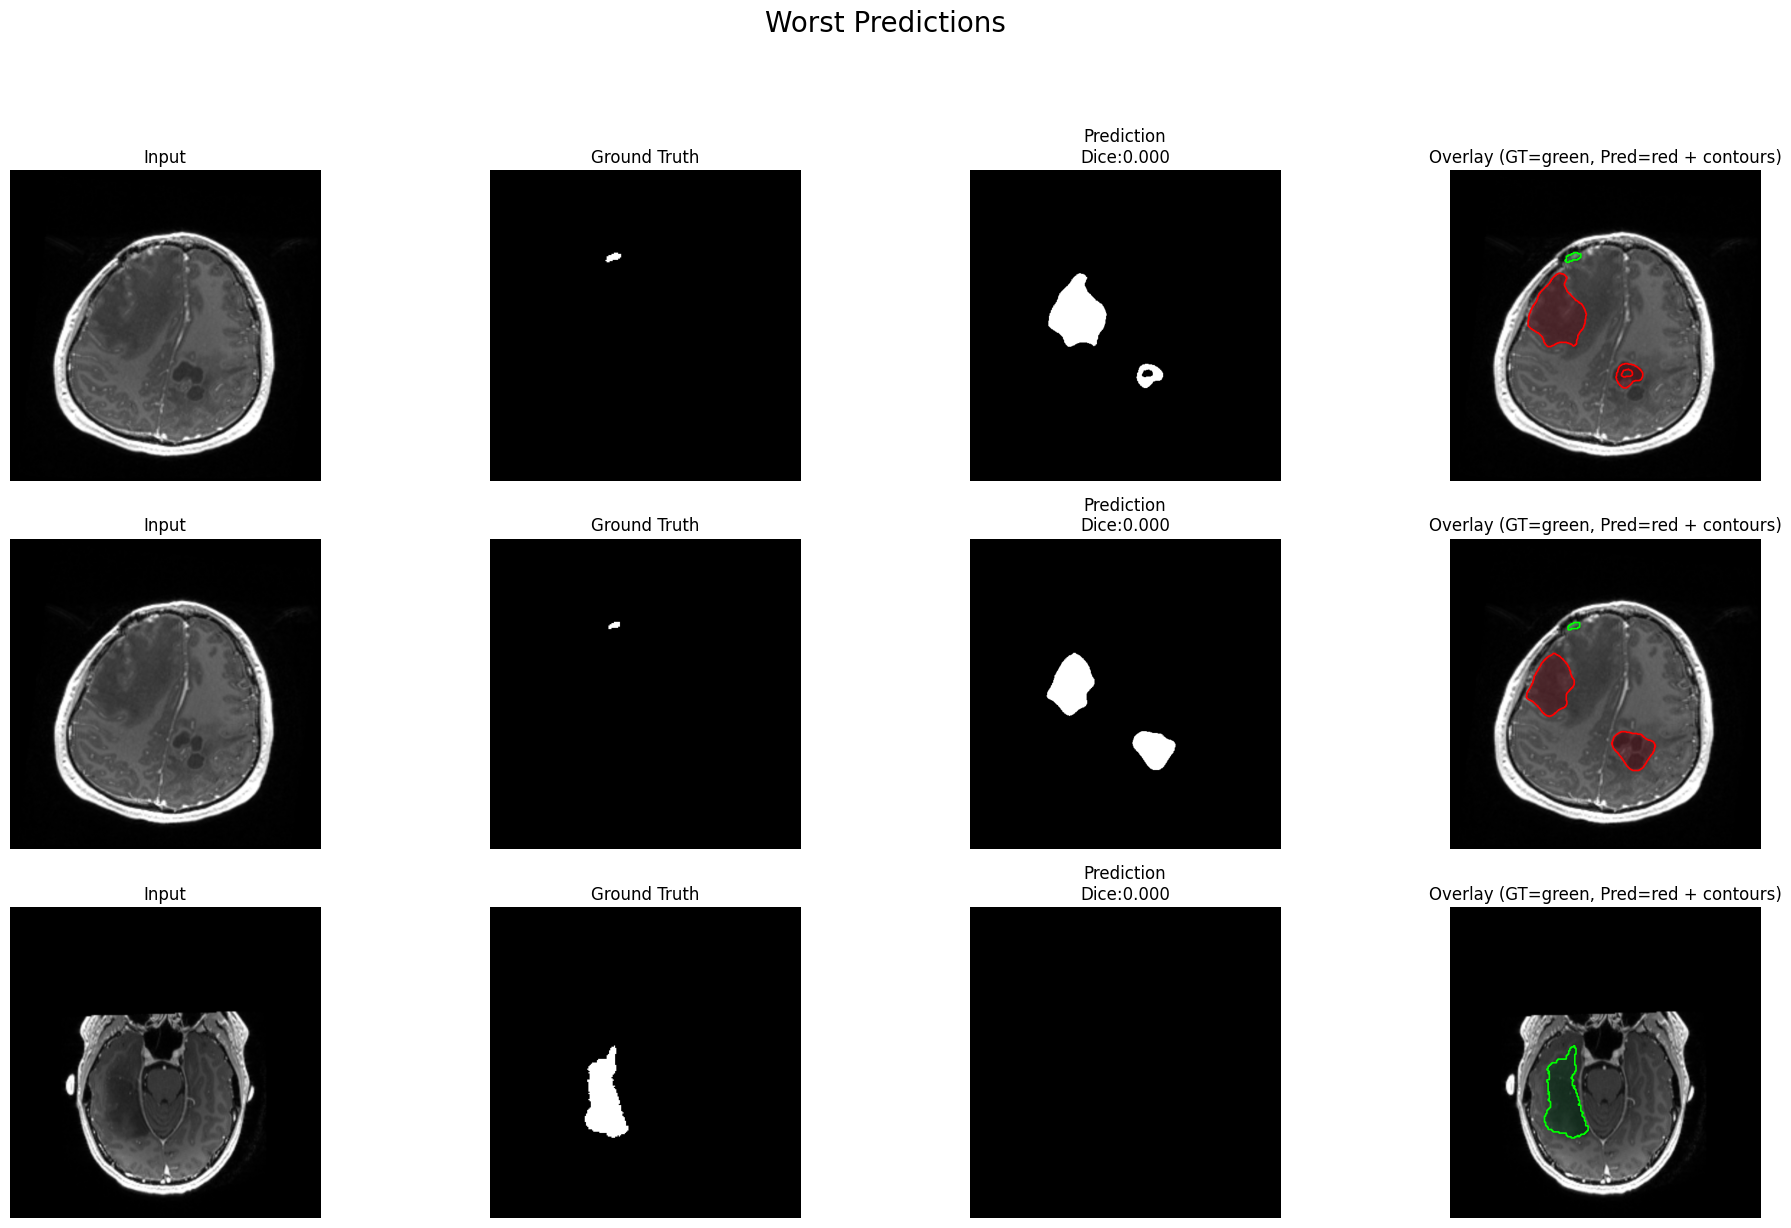

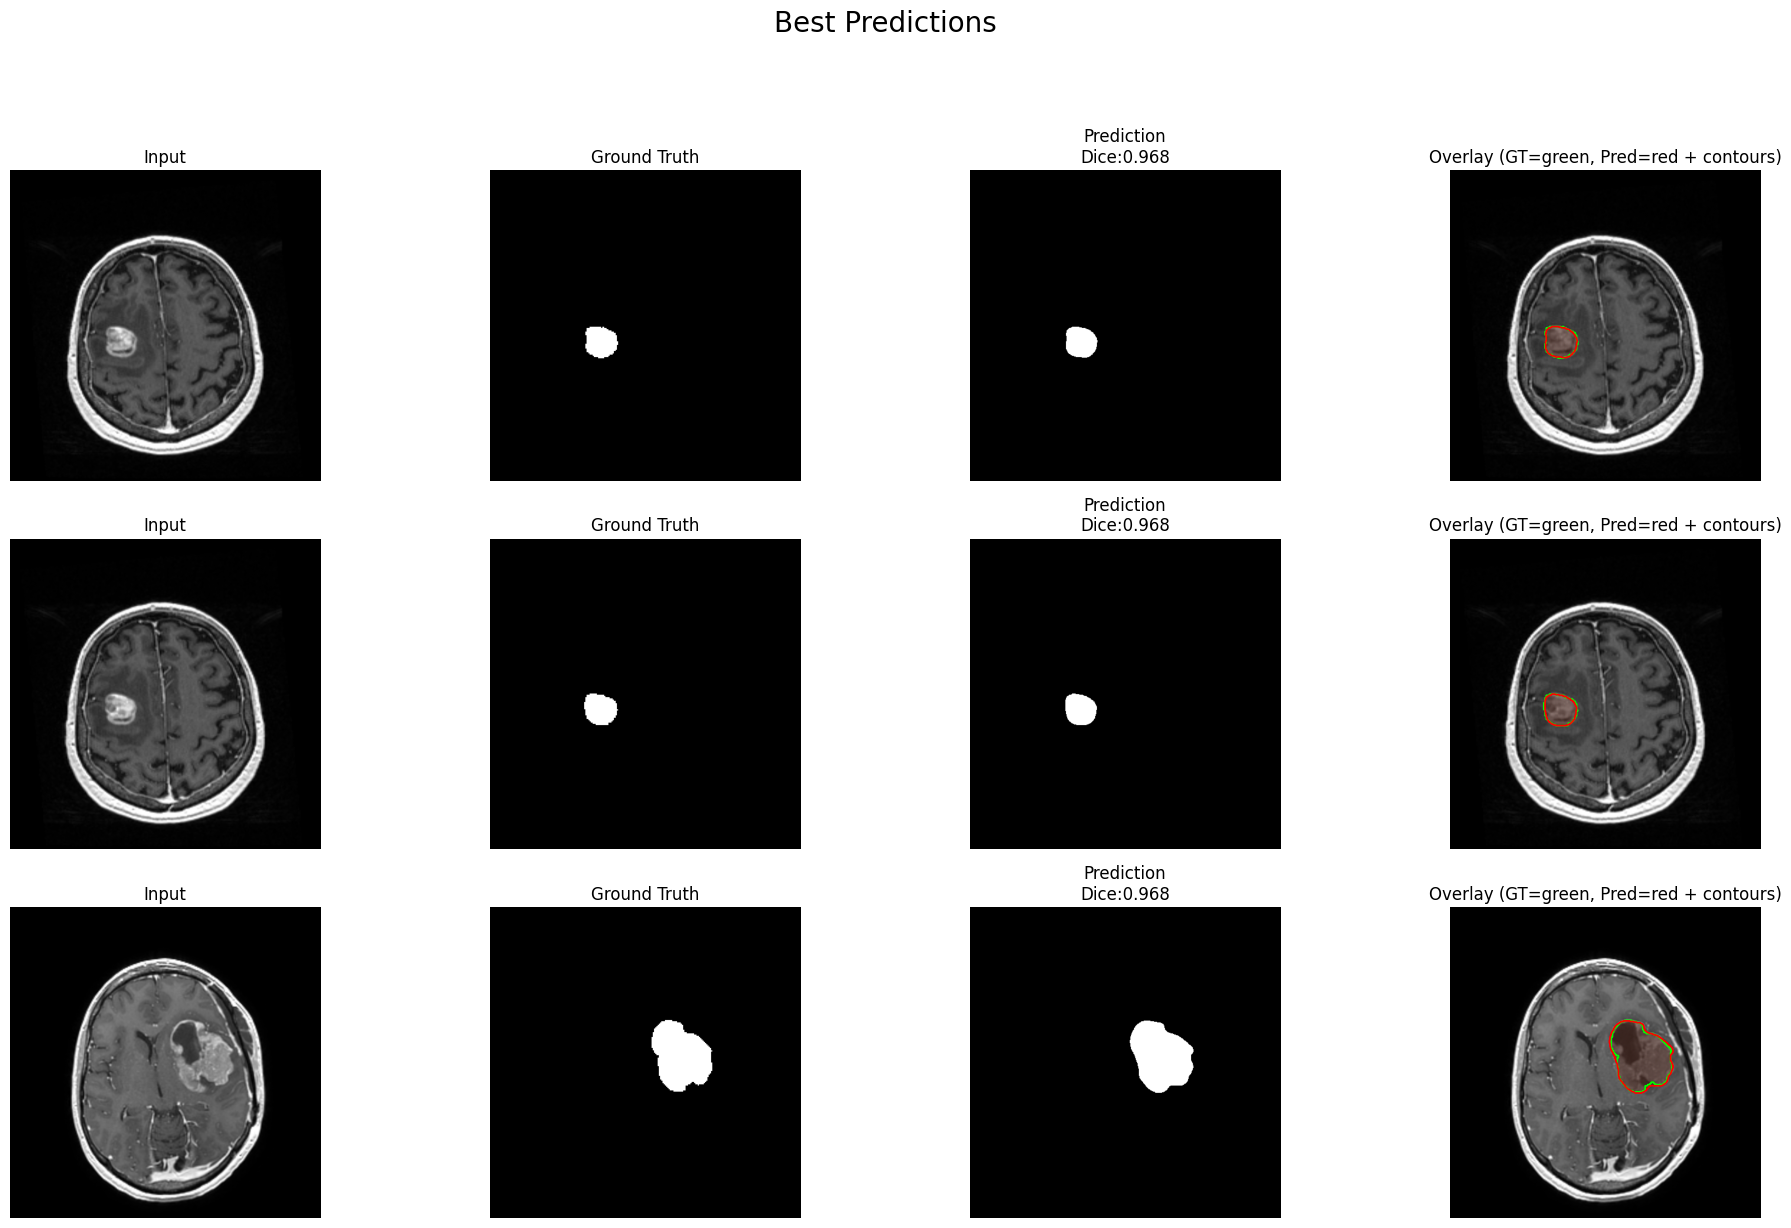

In [ ]:
def visualize_best_and_worst(model, dataset, n=3, device="cuda", contour_width=1.2):
    model.eval(); results = []
    for i in tqdm(range(len(dataset)), desc="Gathering predictions"):
        img_t, msk_t = dataset[i]
        with torch.no_grad():
            logits = model(img_t.unsqueeze(0).to(device))
            pred_t = (torch.sigmoid(logits) > 0.5).float()
            dice = dice_coefficient(pred_t, msk_t.to(device)).item()  # Dice on binarized pred
        results.append({
            'dice': dice,
            'img': img_t.squeeze().numpy(),
            'msk': msk_t.squeeze().numpy(),
            'pred': pred_t.cpu().squeeze().numpy()
        })
    results.sort(key=lambda x: x['dice'])
    def plot(cases, title):
        fig, axes = plt.subplots(len(cases), 4, figsize=(20, 4*len(cases)))
        fig.suptitle(title, fontsize=20, y=1.02)
        for i, case in enumerate(cases):
            ax = axes if len(cases) == 1 else axes[i]
            ax[0].imshow(case['img'], cmap='gray'); ax[0].set_title("Input"); ax[0].axis('off')
            ax[1].imshow(case['msk'], cmap='gray'); ax[1].set_title("Ground Truth"); ax[1].axis('off')
            ax[2].imshow(case['pred'], cmap='gray'); ax[2].set_title(f"Prediction\nDice:{case['dice']:.3f}"); ax[2].axis('off')
            # Overlay: GT in green, Pred in red (with contours)
            gt = case['msk'] > 0.5
            pr = case['pred'] > 0.5
            ax[3].imshow(case['img'], cmap='gray')
            ax[3].imshow(np.ma.masked_where(~gt, gt), cmap='Greens', alpha=0.35, vmin=0, vmax=1)
            ax[3].imshow(np.ma.masked_where(~pr, pr), cmap='Reds',   alpha=0.35, vmin=0, vmax=1)
            # Contours at the 0.5 boundary
            ax[3].contour(gt.astype(float), levels=[0.5], colors='lime', linewidths=contour_width)
            ax[3].contour(pr.astype(float), levels=[0.5], colors='red',  linewidths=contour_width)
            ax[3].set_title("Overlay (GT=green, Pred=red + contours)"); ax[3].axis('off')
        plt.tight_layout(rect=[0,0,1,0.97]); plt.show()
    plot(results[:n],  "Worst Predictions")
    plot(results[-n:], "Best Predictions")

visualize_best_and_worst(final_model, test_ds, n=3)

> 60 minutes in

## Part II: Quality Control

Reimport libraries (if needed)

In [1]:
#@title re-import libraries
# Install the required libraries for our notebook
# segmentation-models-pytorch is a great library with pre-built segmentation model architectures.
# albumentations is a powerful library for data augmentation.
!pip install -U segmentation-models-pytorch albumentations SimpleITK -q

# Library Imports
# Standard libraries
import os
import sys
import warnings
from glob import glob
import math
import time
import gc # Garbage collector to clean RAM

# Data handling and processing
import numpy as np
import pandas as pd
import cv2

# Image processing and visualization
import SimpleITK as sitk
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Deep Learning with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import segmentation_models_pytorch as smp


# Utilities
from tqdm import tqdm
# --- Environment Configuration ---
warnings.filterwarnings(action="ignore")
os.environ["PYTHONWARNINGS"] = "ignore"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This ensures that SimpleITK does not print excessive warnings.
sitk.ProcessObject.SetGlobalWarningDisplay(False)

# Setup reproducibility
import random
RANDOM_SEED   = 42
def set_seed(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(RANDOM_SEED)

print("Libraries imported and environment configured successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 18.3 MB/s eta 0:00:00
Libraries imported and environment configured successfully!


In [3]:
#@title re-load model

# Utility functions for I/O and alignment

def load_dicom_series_to_3d_image(p): return sitk.ReadImage(sitk.ImageSeriesReader().GetGDCMSeriesFileNames(p))
def reconstruct_mask_in_image_space(m, r): return sitk.Resample(m, r, sitk.Transform(), sitk.sitkNearestNeighbor, 0, m.GetPixelID())
def load_volume_any(p): return load_dicom_series_to_3d_image(p) if os.path.isdir(p) else sitk.ReadImage(p)

def normalize_zero_one(x):
    a, b = np.percentile(x, 1), np.percentile(x, 99)
    return np.clip((x - a) / (b - a + 1e-6), 0.0, 1.0)


def discover_patients(p):
    pats = []
    for sub in sorted(glob(os.path.join(p, "sub-*"))):
        idx = os.path.basename(sub).split("-")[-1]
        imgs = glob(os.path.join(sub, "anat", "T1w*"))
        segs = glob(os.path.join(sub, "seg", f"ReMIND-{idx}-preop-SEG-tumor-*.nrrd"))
        if imgs and segs: pats.append({'id': idx, 'img_path': imgs[0], 'seg_path': segs[0]})
    return pats

DATA_PATH = "data/ReMIND"
clinical_df = pd.read_csv(f"{DATA_PATH}/ReMIND_metadata.csv")
clinical_df
# Data Cleaning Step 1: Group Rare Classes
hist_counts = clinical_df["Histopathology"].value_counts()
# Identify all tumor types that appear 2 or fewer times
to_other = hist_counts[hist_counts <= 2].index
clinical_df["Histopathology"] = clinical_df["Histopathology"].replace(to_other, "Other")
print("\nCleaned Histopathology Distribution:\n")
print(clinical_df["Histopathology"].value_counts())
excluded_patients = [7, 16, 4, 19, 22, 23, 27, 35, 41, 43, 47, 60, 76, 92, 95, 114]
clinical_df = clinical_df[~clinical_df["Case Number"].isin(excluded_patients)].reset_index(drop=True)
print(f"Clinical metadata loaded and cleaned. Final patient count: {len(clinical_df)}")

class SegmentationDataset(Dataset):
    def __init__(self, patient_df: pd.DataFrame, data_path: str, size: int = 512, augment: bool = True):
        self.data_path, self.size, self.slices = data_path, size, []
        self.transform = A.Compose([
            A.Resize(size, size, interpolation=1),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.6),
            A.Normalize(mean=0.0, std=1.0), ToTensorV2(),
        ]) if augment else A.Compose([
            A.Resize(size, size, interpolation=1), A.Normalize(mean=0.0, std=1.0), ToTensorV2(),
        ])
        start_time = time.time()
        patients = discover_patients(data_path)
        valid_ids = set(patient_df["Case Number"].astype(str).str.zfill(3))
        patients_to_process = [p for p in patients if p['id'] in valid_ids]
        # print("Filtered patients without available mask:",len(clinical_df) - len(patients_to_process))
        print(f"Indexing {len(patients_to_process)} patients...")
        for pat in tqdm(patients_to_process, desc="Processing Patients"):
          ref_img = load_volume_any(pat['img_path'])
          mask = sitk.ReadImage(pat['seg_path'])
          mask_resampled = reconstruct_mask_in_image_space(mask, ref_img)
          img_np = normalize_zero_one(sitk.GetArrayFromImage(ref_img).astype(np.float32))
          mask_np = sitk.GetArrayFromImage(mask_resampled).astype(np.uint8)
          for k in range(img_np.shape[0]):
              if mask_np[k].any(): self.slices.append((img_np[k], mask_np[k]))
        print(f"\nDataset ready in {time.time() - start_time:.2f}s.")

    def __len__(self): return len(self.slices)
    def __getitem__(self, idx):
        img, msk = self.slices[idx]; t=self.transform(image=img, mask=msk); return t["image"], t["mask"].unsqueeze(0).float()

# Stratified patient-wise split (if metadata exists), else random
from sklearn.model_selection import train_test_split

patient_data = (clinical_df[["Case Number","Histopathology"]]
                .drop_duplicates()
                .set_index("Case Number"))
patient_list = patient_data.index.to_numpy()
patient_labels = patient_data["Histopathology"].to_numpy()
print(f"Total patients: {len(patient_list)}")
print(f"Total labels: {len(patient_labels)}")

pt_train, pt_temp, lb_train, lb_temp = train_test_split(
    patient_list, patient_labels, test_size=0.3, stratify=patient_labels, random_state=RANDOM_SEED
)
pt_val, pt_test, _, _ = train_test_split(
    pt_temp, lb_temp, test_size=(2/3.0), stratify=lb_temp, random_state=RANDOM_SEED
)

train_df = clinical_df[clinical_df["Case Number"].isin(pt_train)]
val_df   = clinical_df[clinical_df["Case Number"].isin(pt_val)]
test_df  = clinical_df[clinical_df["Case Number"].isin(pt_test)]

print("Split sizes (patients if available):")
if "Case Number" in clinical_df and len(clinical_df)>0:
    print("Train:", len(pt_train), " Val:", len(pt_val), " Test:", len(pt_test))

# Build datasets/loaders
BATCH_SIZE = 8
NUM_WORKERS = 2

# train_ds = SegmentationDataset(train_df, DATA_PATH, size=512, augment=True)
# val_ds   = SegmentationDataset(val_df,   DATA_PATH, size=512, augment=False)

# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
# val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# print(f"DataLoaders ready. Train: {len(train_ds)}, Validation: {len(val_ds)}")

def dice_coefficient(logits, targets, smooth=1.0):
    preds = (torch.sigmoid(logits) > 0.5).float()
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    union = preds_flat.sum() + targets_flat.sum()
    return ((2. * intersection + smooth) / (union + smooth))
# Standard BCE Loss with logits
bce_loss = nn.BCEWithLogitsLoss()
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        p = probs.view(-1); t = targets.view(-1)
        inter = (p * t).sum()
        dice  = (2*inter + self.smooth) / (p.sum() + t.sum() + self.smooth)
        return 1 - dice
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    def forward(self, logits, targets):
        return 0.5*self.bce(logits, targets) + 0.5*self.dice(logits, targets)
# SOLUTION for Q3
def compute_iou(logits, targets, threshold=0.5, eps=1e-7):
    preds = (torch.sigmoid(logits) > threshold).float()
    t = (targets > 0.5).float()
    inter = (preds * t).sum()
    union = preds.sum() + t.sum() - inter
    iou = ((inter + eps) / (union + eps))
    return iou.item()

def compute_precision_recall(logits, targets, threshold=0.5, eps=1e-7):
    preds = (torch.sigmoid(logits) > threshold).float()
    t = (targets > 0.5).float()
    TP = (preds * t).sum()
    FP = (preds * (1 - t)).sum()
    FN = ((1 - preds) * t).sum()
    precision = (TP + eps) / (TP + FP + eps)
    recall    = (TP + eps) / (TP + FN + eps)
    return precision.item(), recall.item()

test_ds  = SegmentationDataset(test_df,  DATA_PATH, size=512, augment=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
print(f"DataLoaders ready. Test: {len(test_ds)}")


Cleaned Histopathology Distribution:

Histopathology
Astrocytoma          33
Glioblastoma         31
Other                26
Oligodendroglioma    24
Name: count, dtype: int64
Clinical metadata loaded and cleaned. Final patient count: 98
Total patients: 98
Total labels: 98
Split sizes (patients if available):
Train: 68  Val: 10  Test: 20
Indexing 18 patients...


Processing Patients: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s]


Dataset ready in 14.89s.
DataLoaders ready. Test: 673


## 6. Advanced Topic I: Quality Control via Uncertainty

A good model knows what it knows, but a *great* model knows what it *doesn't* know. We will now use **Monte Carlo (MC) Dropout** to estimate our model's uncertainty.

> ### Deep Dive: Understanding and Quantifying Uncertainty
>
> In machine learning, not all errors are equal. Uncertainty quantification aims to distinguish between two fundamental types of uncertainty:
> - **Aleatoric Uncertainty (Data Uncertainty):** This is uncertainty inherent in the data itself. It's caused by noise, measurement errors, or ambiguity. For example, a blurry part of an MRI scan has high aleatoric uncertainty. This type of uncertainty *cannot* be reduced by collecting more data.
> - **Epistemic Uncertainty (Model Uncertainty):** This reflects the model's own ignorance about the data. It's high in regions of the input space where the model has seen little or no training data. For example, a very rare type of tumor might cause high epistemic uncertainty. This type of uncertainty *can* be reduced by training the model on more diverse data.
>
> **Monte Carlo (MC) Dropout:** This is a clever and computationally cheap technique to estimate *epistemic* uncertainty. The key idea, proposed by Gal & Ghahramani (2016), is to keep the `Dropout` layers (normally only active during training) turned ON during inference.
> 1. We perform `N` stochastic forward passes on the same input image. Each pass is different because dropout randomly "switches off" different neurons.
> 2. This process generates `N` different prediction masks. It's like getting `N` second opinions from slightly different "sub-networks" within our main model.
> 3. We then compute statistics across these `N` masks:
>     - The **mean** of the predictions gives us a robust, ensemble-like segmentation.
>     - The **variance** of the predictions serves as our uncertainty map. If the sub-networks disagree on a region, the variance will be high, signaling high model uncertainty.
>
> **In a nutshell:** MC Dropout simulates an ensemble of models by using dropout at test time, allowing us to measure model disagreement (variance) as a proxy for its confidence.

### 6.1. Model with Dropout and MC Inference (7 minutes)

We'll define a special U-Net with a `Dropout` layer at its bottleneck. By keeping this layer active during inference and running the model multiple times, we get a distribution of predictions. The **variance** of this distribution is our uncertainty map.

In [ ]:
try:
  # Pick best of all automatically
  best_key = max(results.keys(), key=lambda k: results[k]['best_val_dice'])
  best_ckpt = results[best_key]["ckpt"]
  print("Using best model:", best_key, "->", best_ckpt)
except:
  best_checkpoint = './checkpoints_BCE/best.pt'  #@param {type: "string"}
  best_ckpt = best_checkpoint
  print("Using best model:", best_ckpt)

# Define a U-Net variant that has a dropout layer we can activate for MC-Dropout
class UnetWithBottleneckDropout(smp.Unet):
    def __init__(self, dropout_rate=0.5, **kwargs):
        super().__init__(**kwargs)
        self.bottleneck_dropout = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        features = self.encoder(x)
        # Apply dropout to the deepest feature map (the bottleneck)
        features[-1] = self.bottleneck_dropout(features[-1])
        decoder_output = self.decoder(features)
        return self.segmentation_head(decoder_output)

def enable_dropout(model):
    """Activates dropout layers for inference."""
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

# Load our best fine-tuned model's weights into this new architecture
final_model = UnetWithBottleneckDropout(
    encoder_name="resnet50", encoder_weights=None, in_channels=1, classes=1
).to(device)
final_model.load_state_dict(torch.load(best_checkpoint, map_location=device))
print("Uncertainty-capable model loaded with best weights.")

# MC Dropout Inference Function
def perform_mc_inference(model, loader, device, num_samples=25):
    """Performs MC Dropout on an entire dataset and returns detailed results."""
    model.eval()
    enable_dropout(model) # Keep dropout active

    mc_results = []
    for img_t, msk_t in tqdm(loader, desc="MC Inference on Test Set"):
        img_t, msk_t = img_t.to(device), msk_t.to(device)

        stochastic_preds = []
        with torch.no_grad():
            for _ in range(num_samples):
                stochastic_preds.append(torch.sigmoid(model(img_t)))

        # Stack predictions and compute mean and variance
        predictions_stack = torch.stack(stochastic_preds)
        mean_pred = predictions_stack.mean(dim=0)
        variance_map = predictions_stack.var(dim=0)

        # Store all relevant data, moving to CPU to save GPU memory
        mc_results.append({
            'img': img_t.cpu(), 'mask': msk_t.cpu(),
            'mean_pred': mean_pred.cpu(), 'variance_map': variance_map.cpu(),
            'avg_variance': variance_map.mean().item() # A single score for sorting
        })
    return mc_results

# Run MC inference on the test set (this will take time)
test_loader_single_batch = DataLoader(test_ds, batch_size=1, shuffle=False)
mc_results = perform_mc_inference(final_model, test_loader_single_batch, device)

# Sort cases from most uncertain to least uncertain
mc_results.sort(key=lambda x: x['avg_variance'], reverse=True)
print(f"\nMC Dropout complete. Most uncertain case has avg variance: {mc_results[0]['avg_variance']:.6f}")

Using best model: ./checkpoints_BCE/best.pt
Uncertainty-capable model loaded with best weights.


MC Inference on Test Set:   7%|▋         | 49/673 [00:31<06:31,  1.59it/s]

Run the next cell to download the pre-computed features (in case of low resources)

In [ ]:
!hf download albarqouni/bild-dataset --repo-type dataset --include "Segmentation/mc_results.pkl" --local-dir ./
import pickle

input_path = "./Segmentation/mc_results.pkl"
with open(input_path, 'rb') as f:
    mc_results = pickle.load(f)

print(f"mc_results loaded from {input_path}")

### 6.2. Finding and Analyzing Difficult Cases with Uncertainty

Now we can use our uncertainty metric to automatically find the cases the model was least confident about.

**Q5 Analysis**: After running the uncertainty analysis, look at the most uncertain cases. Do regions of high uncertainty (hot colors) correspond to tumor boundaries, complex anatomy, or areas where the model made a clear mistake?

In [52]:
#@title Helper function to plot uncertain cases
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from matplotlib.lines import Line2D

def plot_uncertain_cases(
    results, num_cases=10, thr=0.5, overlay_alpha=0.40, unc_alpha=0.45,
    var_mode="pred", band=(0.4, 0.6), var_clip=(1, 99),
    contour_width=1.5, add_pred_contour=True, compute_dice=True,
    sort_by_uncertainty=True,
    shuffle=True,           # randomize the order shown
    seed=None,               # set for reproducibility
    top_k=None               # take from top-K most uncertain before shuffling
):
    rng = np.random.default_rng(seed)

    # keep your existing to_np + (optional) sorting
    def to_np(x):
        x = x.detach().cpu().numpy() if hasattr(x, "detach") else np.asarray(x)
        while x.ndim > 2: x = x[0]
        return x

    if sort_by_uncertainty and results and ('avg_variance' in results[0]):
        results = sorted(results, key=lambda c: c.get('avg_variance', 0.0), reverse=True)

    # choose pool (top_k) and optionally shuffle
    pool = results[:top_k] if (top_k is not None) else results
    if shuffle:
        pool = pool.copy()
        rng.shuffle(pool)

    print(f"--- Displaying {min(num_cases, len(pool))} Most Uncertain (pool={len(pool)}; "
          f"{'shuffled' if shuffle else 'ordered'}) ---")

    # iterate over the (maybe shuffled) pool
    for i in range(min(num_cases, len(pool))):
        case = pool[i]
        # case    = results[i]
        img     = to_np(case['img'])
        gt      = (to_np(case['mask']) > 0.5)
        mean_p  = to_np(case['mean_pred'])
        var_map = to_np(case['variance_map'])
        pred    = (mean_p > thr)

        dice = None
        if compute_dice:
            inter = np.logical_and(pred, gt).sum()
            denom = pred.sum() + gt.sum()
            dice  = (2.0 * inter) / (denom + 1e-8)

        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        st = f"Case #{i+1} Most Uncertain"
        if 'avg_variance' in case:
            st += f" | Avg Var: {case['avg_variance']:.6f}"
        fig.suptitle(st, fontsize=16)

        # Original
        ax = axes[0]
        ax.imshow(img, cmap='gray'); ax.set_title('Original MRI'); ax.axis('off')

        # Segmentation overlay
        ax = axes[1]
        ax.imshow(img, cmap='gray')

        red = np.zeros((*pred.shape, 4), float)
        red[..., 0] = pred.astype(float)
        red[..., 3] = pred.astype(float) * overlay_alpha
        ax.imshow(red)

        if gt.any():
            for c in measure.find_contours(gt.astype(float), 0.5):
                ax.plot(c[:, 1], c[:, 0], color='lime', linewidth=contour_width)
        if add_pred_contour and pred.any():
            for c in measure.find_contours(pred.astype(float), 0.5):
                ax.plot(c[:, 1], c[:, 0], color='red', linewidth=contour_width, linestyle='--')

        title = 'Segmentation Overlay'
        if dice is not None:
            title += f'\nDice = {dice:.4f}'
        ax.set_title(title)
        # Explicit handles (avoid single-arg legend parsing issue)
        legend_handles = [
            Line2D([], [], color='lime', lw=contour_width, label='GT'),
            Line2D([], [], color='red',  lw=contour_width, ls='--', label='Pred')
        ]
        ax.legend(handles=legend_handles, loc='lower right', frameon=True)
        ax.axis('off')

        # Uncertainty overlay (variance), masked + percentile clip
        ax = axes[2]
        ax.imshow(img, cmap='gray')

        if var_mode == "pred":
            mask = pred
        elif var_mode == "union":
            mask = np.logical_or(pred, gt)
        elif var_mode == "band":
            lb, ub = band
            mask = (mean_p >= lb) & (mean_p <= ub)
        else:  # 'all'
            mask = np.ones_like(var_map, dtype=bool)

        safe_var = np.nan_to_num(var_map, nan=0.0, posinf=0.0, neginf=0.0)
        mvar = np.ma.masked_where(~mask, safe_var)
        if mask.any():
            vmin, vmax = np.nanpercentile(safe_var[mask], var_clip)
        else:
            vmin, vmax = np.nanpercentile(safe_var, var_clip)

        im3 = ax.imshow(mvar, cmap='hot', alpha=unc_alpha, vmin=vmin, vmax=vmax)
        ax.set_title('Uncertainty Overlay'); ax.axis('off')
        cb = fig.colorbar(im3, ax=ax, fraction=0.046, pad=0.04); cb.set_label('Variance')

        plt.tight_layout(rect=[0, 0, 1, 0.93]); plt.show()

# Simple version
def plot_uncertain_cases_simple(results, num_cases=5):
    """Plots the most uncertain cases from MC-Dropout results."""
    print(f"--- Displaying the {num_cases} Most Uncertain Predictions ---")
    for i in range(min(num_cases, len(results))):
        case = results[i]
        img, mask = case['img'][0, 0], case['mask'][0, 0]
        mean_p, var_map = case['mean_pred'][0, 0], case['variance_map'][0, 0]

        fig, axes = plt.subplots(1, 4, figsize=(22, 6))
        fig.suptitle(f"Case #{i+1} Most Uncertain | Avg Variance: {case['avg_variance']:.6f}", fontsize=16)

        axes[0].imshow(img, cmap='gray'); axes[0].set_title('Input MRI'); axes[0].axis('off')
        axes[1].imshow(mask, cmap='gray'); axes[1].set_title('Ground Truth'); axes[1].axis('off')

        im2 = axes[2].imshow(mean_p, cmap='viridis'); axes[2].set_title('Mean Prediction'); axes[2].axis('off')
        fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

        im3 = axes[3].imshow(var_map, cmap='hot'); axes[3].set_title('Uncertainty (Variance)'); axes[3].axis('off')
        fig.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

        plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

--- Displaying 5 Most Uncertain (pool=664; shuffled) ---


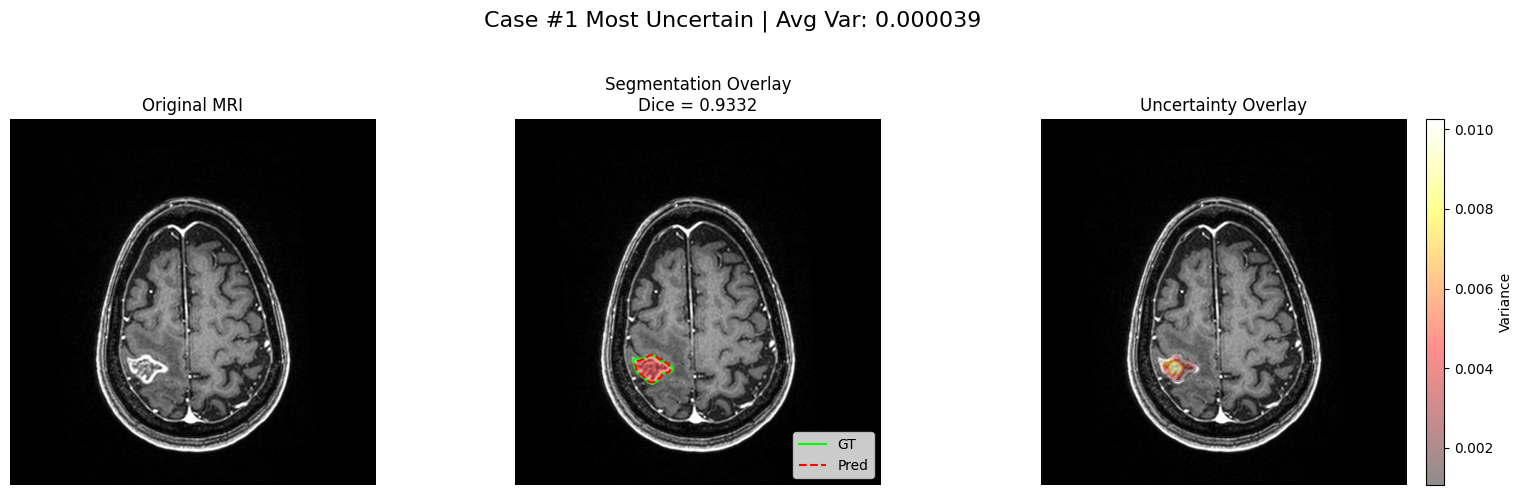

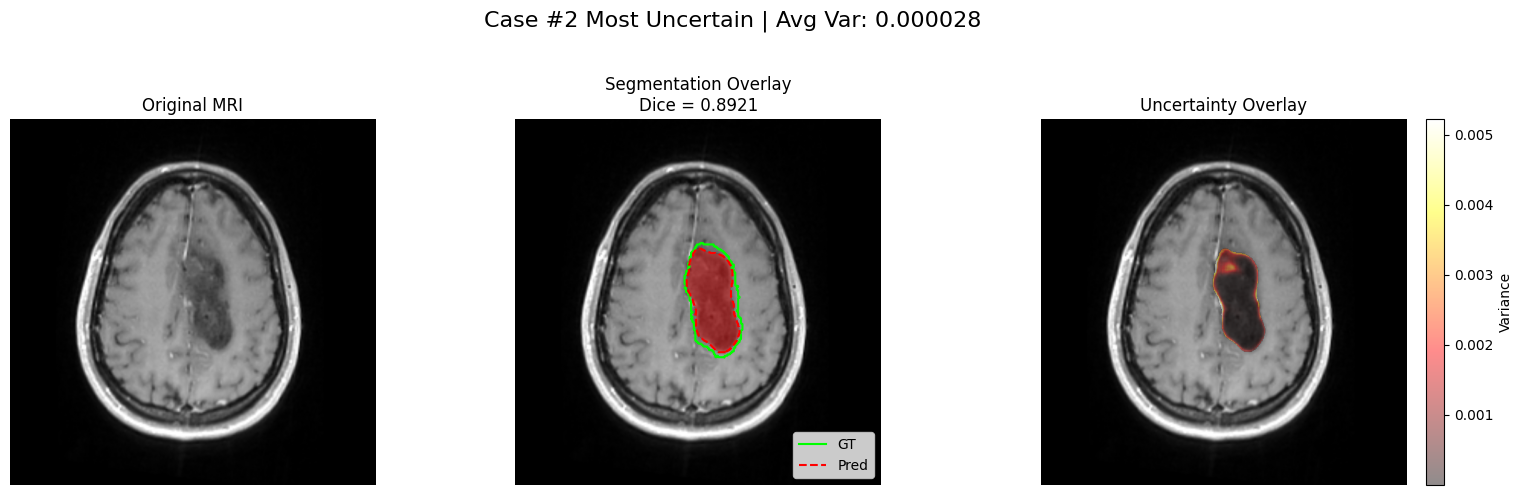

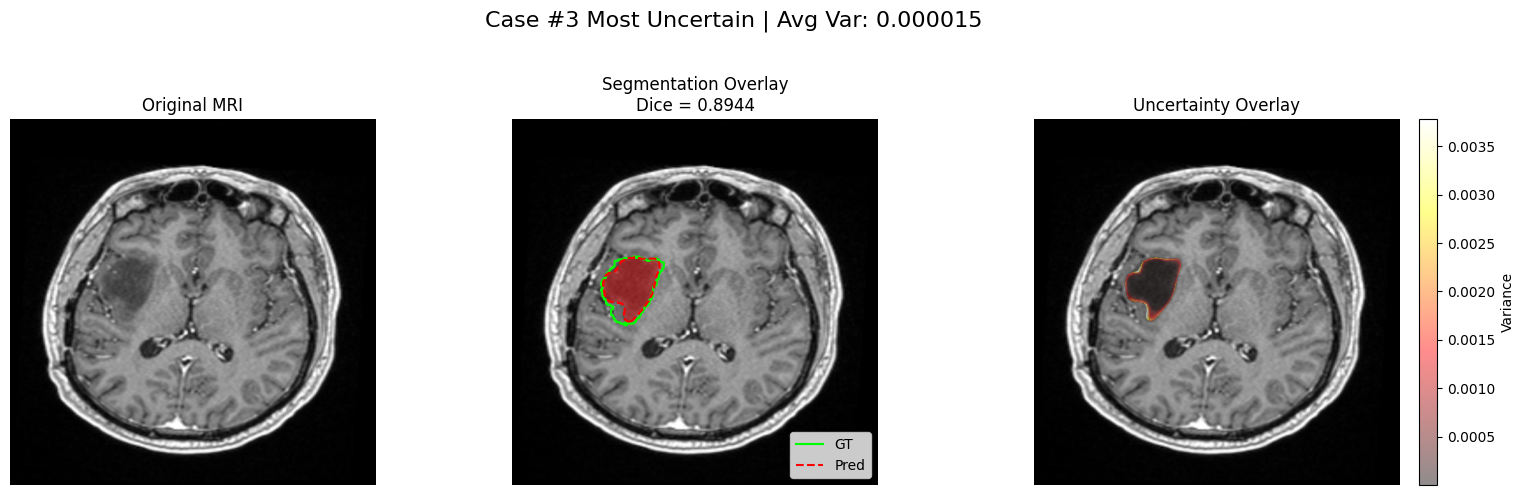

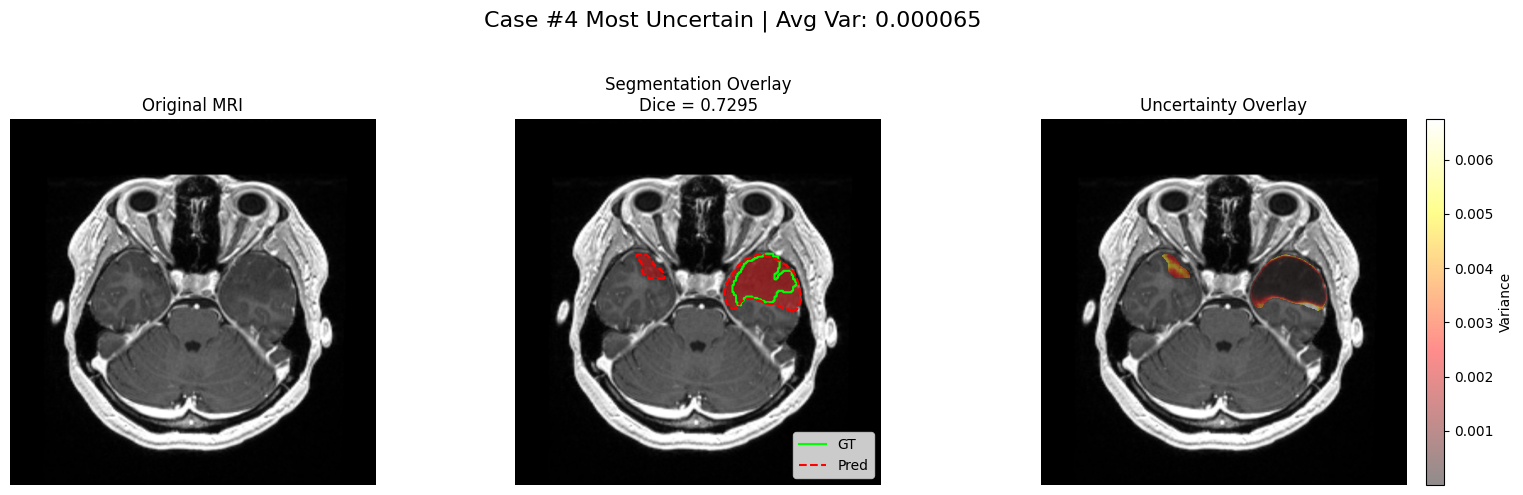

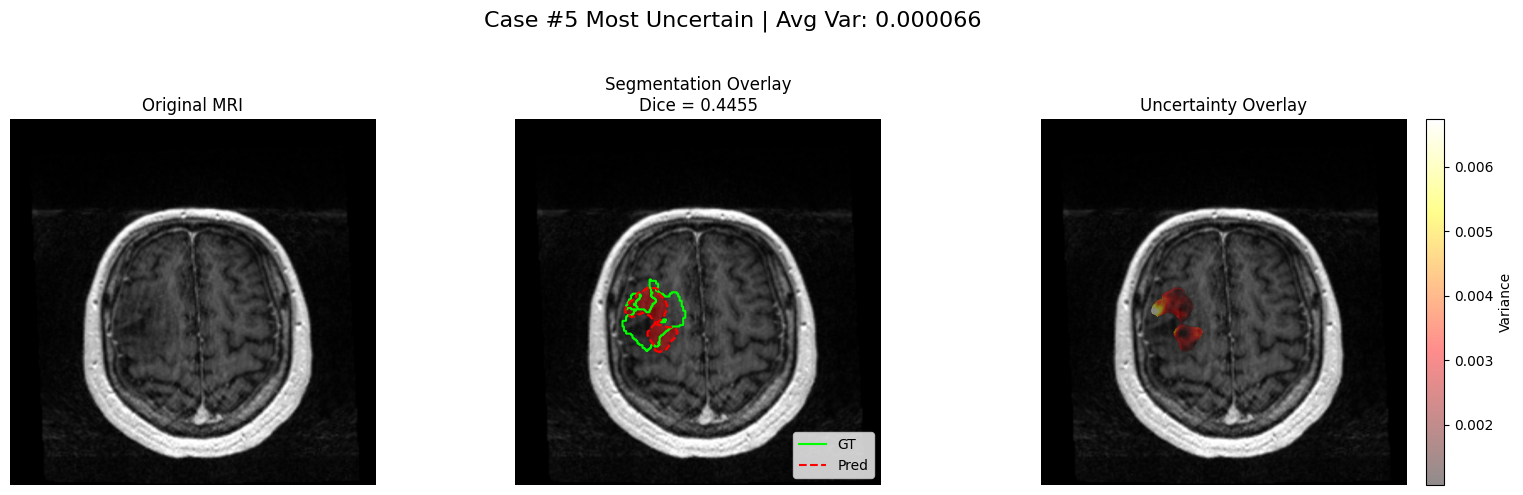

In [51]:
plot_uncertain_cases(mc_results, num_cases=5, shuffle=True, seed=RANDOM_SEED)


### 6.3. Final Check: Does Uncertainty Correlate with Error?

Our hypothesis is that high uncertainty should correlate with low performance (i.e., low Dice score). Let's test this directly by plotting average variance against the Dice score for every sample in the test set. A negative correlation would validate our uncertainty metric.

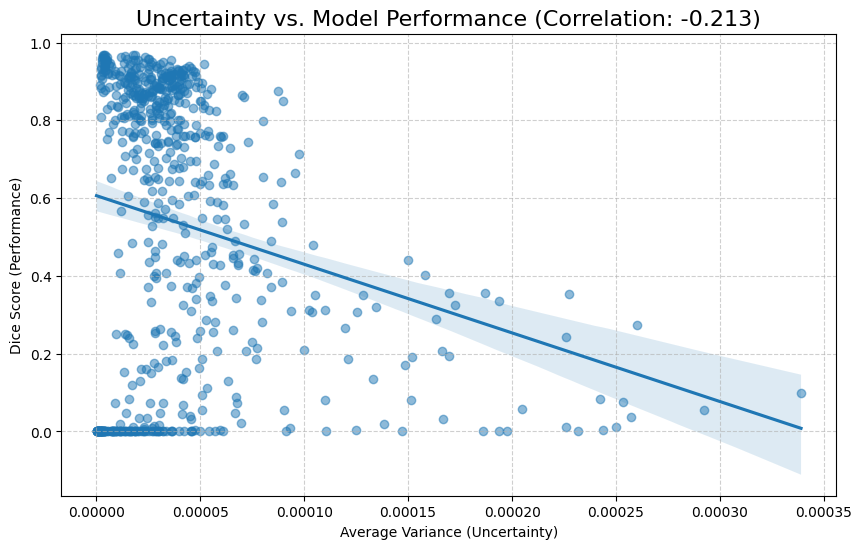

In [45]:
# Calculate Dice score for each case in our MC results
def dice_numpy(pred, target, smooth=1e-6):
    p_flat = (pred > 0.5).flatten()
    t_flat = (target > 0.5).flatten()
    intersection = (p_flat & t_flat).sum()
    union = p_flat.sum() + t_flat.sum()
    return (2. * intersection + smooth) / (union + smooth)

for case in mc_results:
    case['dice_score'] = dice_numpy(case['mean_pred'].numpy(), case['mask'].numpy())

# Extract data for plotting
variances = [case['avg_variance'] for case in mc_results]
dice_scores = [case['dice_score'] for case in mc_results]

# Calculate the Pearson correlation coefficient
correlation = np.corrcoef(variances, dice_scores)[0, 1]

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.regplot(x=variances, y=dice_scores, scatter_kws={'alpha':0.5})
plt.title(f'Uncertainty vs. Model Performance (Correlation: {correlation:.3f})', fontsize=16)
plt.xlabel('Average Variance (Uncertainty)')
plt.ylabel('Dice Score (Performance)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


The negative correlation confirms it: **higher uncertainty is a strong indicator of a poorer segmentation**. We can now confidently use this metric to flag cases for review.

> 75 minutes in

## 7. Advanced Topic II: Prompt-based Segmentation with MedSAM

We've built a great model, but how does it stack up against a massive, pre-trained **Foundation Model**? We'll now evaluate **MedSAM**, a version of the Segment Anything Model adapted for medical images.

MedSAM is **prompt-based**: you give it an image and a "prompt" (like a bounding box) to tell it what to segment. This makes it incredibly flexible. For a fair comparison, we'll "cheat" by giving it the perfect prompt: the bounding box derived from the ground truth mask.

> We evaluate MedSAM with a **bounding-box from the ground truth** to simulate a best-case clinical prompt.

### Q6: Evaluate MedSAM's Performance
**Your Task**: Run the following cells to install MedSAM, load its weights, and evaluate its performance on our validation set. Compare the final Dice score to the one you achieved with your U-Net.

#### Setup MedSAM (8 minutes)

In [46]:
# Setup MedSAM
# Optional install (only needed once)
!pip install -q git+https://github.com/bowang-lab/MedSAM.git

# Download MedSAM weights if not present (~350MB)
MEDSAM_WEIGHTS_PATH = "./medsam_vit_b.pth"
if not os.path.exists(MEDSAM_WEIGHTS_PATH):
    print("Downloading MedSAM weights...")
    !wget -q -O {MEDSAM_WEIGHTS_PATH} https://zenodo.org/records/10689643/files/medsam_vit_b.pth

medsam_model = None
try:
    from segment_anything import sam_model_registry
    medsam_model = sam_model_registry['vit_b'](checkpoint=MEDSAM_WEIGHTS_PATH).to(device).eval()
    print("MedSAM model loaded successfully.")
except Exception as e:
    print(f"Could not load MedSAM. Skipping this section. Error: {e}")

MedSAM model loaded successfully.


#### MedSAM Helper Functions: Engine of Prompt-Based Inference

To interact with a powerful foundation model like MedSAM, we use two key helper functions. Together, they form a robust pipeline to query the model, turning a simple box prompt into a high-resolution segmentation.

#### `get_bounding_box_from_mask(mask_tensor)`

This utility function acts as our "digital ruler." It takes a ground truth segmentation mask and automatically calculates the tightest possible bounding box around the region of interest (the tumor). It finds all non-zero pixels in the mask, identifies their minimum and maximum coordinates, and returns them in the standard `[x_min, y_min, x_max, y_max]` format. This is essential for generating the "perfect" prompt needed for our systematic evaluation.

#### `medsam_inference_with_box(...)`

This is the main workhorse function that orchestrates the MedSAM prediction. Its workflow involves several key steps:

*   **Coordinate Normalization**: This is the most critical step for performance. It translates the bounding box coordinates from our image's space into MedSAM's native 1024x1024 space, which is what its `prompt_encoder` expects.
*   **Prompt Encoding**: The normalized box is converted into mathematical embeddings that represent the spatial query.
*   **Mask Decoding**: The model's `mask_decoder` intelligently fuses information from the **image embedding** (what the image contains) with the **prompt embedding** (what we want to segment) to produce a low-resolution prediction.
*   **Upsampling and Binarization**: This low-resolution output is upsampled to the original image size using bilinear interpolation and then converted into a final, clean binary mask by applying a sigmoid and a 0.5 threshold.


In [47]:
def get_bounding_box_from_mask(mask_tensor):
    """Extracts the bounding box [x_min, y_min, x_max, y_max] from a binary mask tensor."""
    coords = torch.nonzero(mask_tensor.squeeze())
    if coords.numel() == 0: return [0, 0, 1, 1] # Fallback for empty mask
    y_min, x_min = coords.min(0).values
    y_max, x_max = coords.max(0).values
    return [x_min.item(), y_min.item(), x_max.item(), y_max.item()]

@torch.no_grad()
def medsam_inference_with_box(model, img_embedding, box_prompt, original_img_size):
    """
    Performs MedSAM inference using a bounding box prompt.
    Handles coordinate normalization internally.
    """
    H, W = original_img_size
    # SAM's prompt encoder expects coordinates normalized to its native 1024x1024 space.
    # This is a key step for performance.
    box_norm = np.array(box_prompt) / np.array([W, H, W, H]) * 1024
    box_torch = torch.as_tensor(box_norm, dtype=torch.float, device=model.device).unsqueeze(0)

    sparse_embeddings, dense_embeddings = model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = model.mask_decoder(
        image_embeddings=img_embedding,
        image_pe=model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
    # Upsample the low-resolution mask to the original image size
    upscaled_logits = nn.functional.interpolate(
        low_res_logits,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )
    # Return the final binary mask
    return (torch.sigmoid(upscaled_logits) > 0.5).float()

#### Run MedSAM Validation

To streamline the process of testing the MedSAM model and to make our experimentation more robust, we have encapsulated the entire evaluation workflow into a single, comprehensive function: `run_medsam_evaluation`.

This function serves as a self-contained "test harness." It takes the MedSAM model and a DataFrame defining the dataset split (e.g., `val_df` or `test_df`) and returns a dictionary containing a full suite of performance metrics. This approach makes it easy to systematically benchmark the model on different data subsets.

#### How It Works: A Step-by-Step Breakdown

The function executes the following logical steps:

1.  **Data Preparation**: It begins by creating a new `SegmentationDataset` and `DataLoader` instance, specifically configured with the image `size` required by MedSAM (typically 1024x1024).
2.  **Iterating Through the Dataset**: It loops through every single sample in the provided data loader.
3.  **Image Preprocessing**: MedSAM's Vision Transformer (ViT) encoder was trained on standard RGB images. Therefore, for each single-channel grayscale MRI slice, the function converts it into a 3-channel image by repeating the channel dimension three times.
4.  **Generating the 'Perfect' Prompt**: To give MedSAM its best chance to perform well, we simulate a perfect user interaction. The function generates a bounding box prompt directly from the ground truth mask for each image.
5.  **Running Inference**: It calls our helper function, `medsam_inference_with_box`, using the prepared image embedding and the bounding box prompt to get the final predicted segmentation mask.
6.  **Calculating Metrics**: The function then calculates a full suite of performance metrics (Dice, IoU, Precision, and Recall) by comparing the model's prediction to the ground truth.

*Note on hard dice*: It is important to note that this function calculates metrics on a **binarized** prediction (i.e., after applying a `> 0.5` threshold to the model's probability outputs). This approach, sometimes called a **"Hard Dice"**, measures how well the final *mask* overlaps with the ground truth. This ensures consistency with how we typically interpret metrics like Precision and Recall.



In [48]:
def run_medsam_evaluation(
    medsam_model,
    df,
    data_path,
    device,
    num_workers=4,
    threshold_iou=0.5,
    threshold_precision_recall=0.5,
    size=1024,
    eps=1e-6
):
    if medsam_model is None:
        print("MedSAM model not provided.")
        return None

    ds_sam = SegmentationDataset(df, data_path, size=size, augment=False)
    loader_sam = DataLoader(ds_sam, batch_size=1, shuffle=False, num_workers=num_workers)

    medsam_dice_scores, medsam_iou, medsam_prec, medsam_rec = [], [], [], []

    start_time = time.time()
    medsam_model.eval()

    for img_t, msk_t in tqdm(loader_sam, desc="MedSAM Evaluation"):
        img_t = img_t.to(device)         # [1, H, W]
        msk_t = (msk_t > 0.5).float().to(device)  # ensure binary GT

        # 3-channel input for MedSAM encoder
        img_3c = img_t.repeat(1, 3, 1, 1)  # [1, 3, H, W]

        # GT-box prompt (coords must match this resized space)
        box_prompt = get_bounding_box_from_mask(msk_t)

        # Get embedding + prediction (probabilities in [0,1])
        with torch.no_grad():
            img_embedding = medsam_model.image_encoder(img_3c)
            pred_prob = medsam_inference_with_box(
                medsam_model, img_embedding, box_prompt, original_img_size=(size, size)
            )  # expected shape [1, H, W] or [H, W]

        # Ensure [H, W] tensor on same device
        if pred_prob.dim() == 3:
            pred_prob = pred_prob.squeeze(0)
        pred_prob = pred_prob.to(device).clamp(0, 1)

        # Metrics
        # Option A: Hard Dice (binary) – matches your IoU/Prec/Rec style
        pred_bin = (pred_prob > threshold_precision_recall).float()

        dice_val = dice_coefficient(pred_bin, msk_t).item()  # <- Dice on binaries

        iou_val  = compute_iou(pred_bin, msk_t, threshold=0.5)  # already binary, thr unused
        p, r     = compute_precision_recall(pred_bin, msk_t, threshold=0.5)

        medsam_dice_scores.append(dice_val)
        medsam_iou.append(iou_val)
        medsam_prec.append(p)
        medsam_rec.append(r)

        # If you instead want soft-dice with probabilities, replace Dice line with:
        # dice_val = soft_dice(pred_prob, msk_t, eps=eps)  # requires a soft_dice implementation

        # Or Dice expecting logits, compute true logits:
        # logits = torch.log(pred_prob + eps) - torch.log(1 - pred_prob + eps)
        # dice_val = dice_coefficient(logits, msk_t).item()

    end_time = time.time()
    print(f"\nMedSAM Finished in {end_time - start_time:.2f} seconds ---")
    print("MedSAM (with GT box prompt)")
    print(f"Dice:      {np.mean(medsam_dice_scores):.4f}")
    print(f"IoU:       {np.mean(medsam_iou):.4f}")
    print(f"Precision: {np.mean(medsam_prec):.4f}")
    print(f"Recall:    {np.mean(medsam_rec):.4f}")

    return {
        "dice_scores": medsam_dice_scores,
        "iou_scores": medsam_iou,
        "precision": medsam_prec,
        "recall": medsam_rec
    }

In [49]:
print("Compute validation")
threshold_iou = 0.5 #@param {type: "slider", min: 0, max: 1, step:0.01}
threshold_precision_recall = 0.5 #@param {type: "slider", min: 0, max: 1, step:0.01}

run_medsam_evaluation(medsam_model,val_df,DATA_PATH,device,num_workers=4,threshold_iou=threshold_iou,threshold_precision_recall=threshold_precision_recall,size=1024)
print("Validation results finished")

Compute validation
Indexing 10 patients...


Processing Patients: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.59it/s]



Dataset ready in 6.44s.


MedSAM Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 402/402 [00:43<00:00,  9.25it/s]


MedSAM Finished in 43.45 seconds ---
MedSAM (with GT box prompt)
Dice:      0.6120
IoU:       0.4643
Precision: 0.7828
Recall:    0.5365
Validation results finished


### 7.2 Visual Comparison: U-Net vs. MedSAM

Metrics tell us the average performance, but a visual comparison can reveal the different qualitative behaviors of the two models. Let's take a random sample from our validation set and see how our fine-tuned, fully automatic U-Net compares to the prompt-driven MedSAM.

The following code will:
1.  Select a sample from the validation set.
2.  Generate a prediction using your best-trained U-Net model.
3.  Generate a prediction using MedSAM with a ground truth bounding box prompt.
4.  Display the input image, ground truth, U-Net prediction, and MedSAM prediction side-by-side.

**Reflection**:
-   Which model produces a "cleaner" or more plausible segmentation?
-   Does one model handle the boundaries better than the other?
-   How does the prompt-based nature of MedSAM influence its output compared to the fully automatic U-Net?


Indexing 18 patients...


Processing Patients: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.96it/s]



Dataset ready in 6.11s.
--- Visualizing Comparison for Sample Index: 200 ---


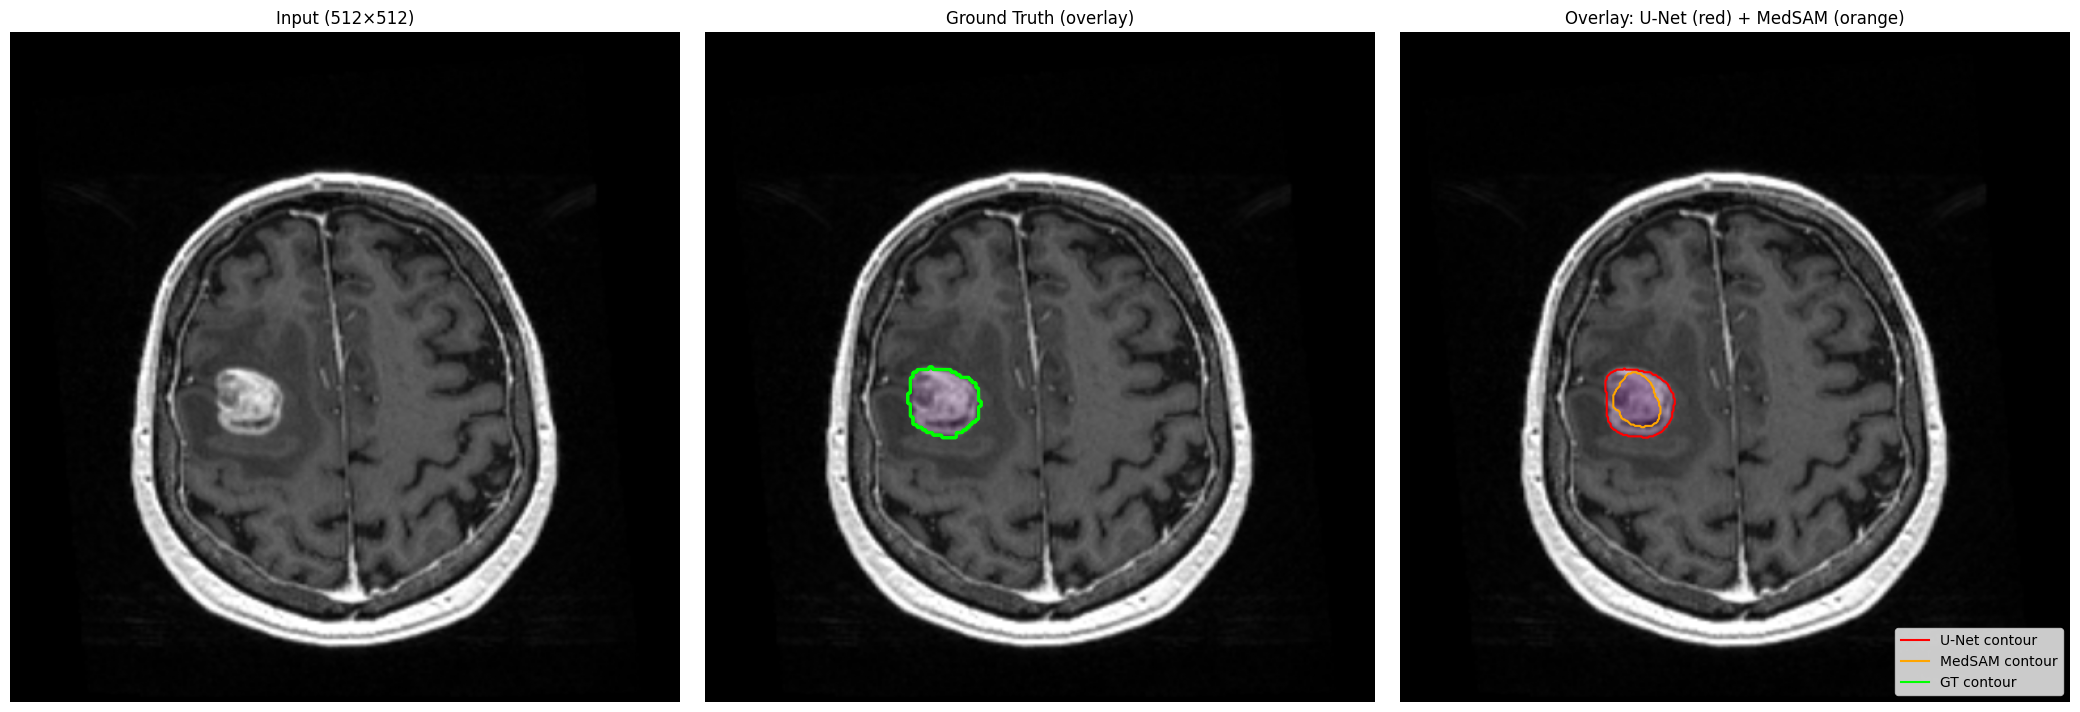

In [55]:
# Visualization Code
def visualize_comparison(
    unet_model,
    medsam_model,
    unet_ds,
    medsam_ds,
    idx_to_show,
    device="cuda",
    thr=0.5,
    overlay_alpha=0.25,
    contour_width=1.5
):
    """
    Compares U-Net and MedSAM predictions for a given sample index, showing:
      - Input image
      - Ground truth
      - Combined overlay: original image + semi-transparent masks + contours
        * U-Net (final model): red contour
        * MedSAM: orange contour
    """
    import torch, numpy as np, matplotlib.pyplot as plt
    import torch.nn.functional as F

    print(f"--- Visualizing Comparison for Sample Index: {idx_to_show} ---")

    # U-Net prediction
    unet_model.eval()
    img_t_unet, msk_t_unet = unet_ds[idx_to_show]    # shapes: [1,H,W]
    with torch.no_grad():
        logits_unet = unet_model(img_t_unet.unsqueeze(0).to(device))  # [1,1,H,W]
        pred_unet = (torch.sigmoid(logits_unet) > thr).float().cpu().squeeze(0).squeeze(0)  # [H,W]

    # MedSAM prediction
    if medsam_model is not None:
        medsam_model.eval()
        img_t_sam, msk_t_sam = medsam_ds[idx_to_show]  # [1,1024,1024]
        with torch.no_grad():
            img_3c = img_t_sam.unsqueeze(0).to(device).repeat(1, 3, 1, 1)  # [1,3,Hs,Ws]
            box     = get_bounding_box_from_mask(msk_t_sam.to(device))     # (x1,y1,x2,y2) or similar
            emb     = medsam_model.image_encoder(img_3c)
            pred_medsam_prob = medsam_inference_with_box(
                medsam_model, emb, box, original_img_size=tuple(img_t_sam.shape[-2:])
            ).cpu().squeeze()  # [Hs,Ws], probs in [0,1]
            pred_medsam = (pred_medsam_prob > thr).float()
    else:
        pred_medsam = torch.zeros_like(pred_unet)
        print("Warning: MedSAM model not available. Showing placeholder for its prediction.")

    # Harmonize sizes for overlay (use U-Net's image as reference)
    H, W = img_t_unet.shape[-2], img_t_unet.shape[-1]
    if pred_medsam.shape != (H, W):
        pred_medsam = F.interpolate(
            pred_medsam[None, None, ...], size=(H, W), mode="nearest"
        ).squeeze(0).squeeze(0)

    # Prepare arrays for plotting
    img_np   = img_t_unet.squeeze().cpu().numpy()      # [H,W] grayscale
    gt_np    = msk_t_unet.squeeze().cpu().numpy()      # [H,W]
    unet_np  = pred_unet.cpu().numpy().astype(np.float32)     # [H,W] {0,1}
    sam_np   = pred_medsam.cpu().numpy().astype(np.float32)   # [H,W] {0,1}

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))

    # 1) Input
    axes[0].imshow(img_np, cmap="gray")
    axes[0].set_title(f'Input ({getattr(unet_ds,"size",W)}×{getattr(unet_ds,"size",H)})')
    axes[0].axis('off')

    # 2) Ground Truth
    axes[1].imshow(img_np, cmap="gray")
    axes[1].imshow(np.ma.masked_where(gt_np == 0, gt_np), alpha=overlay_alpha)
    axes[1].contour(gt_np, colors='lime', linewidths=contour_width)
    axes[1].set_title('Ground Truth (overlay)')
    axes[1].axis('off')

    # 3) Combined overlay (original + both predictions)
    ax = axes[2]
    ax.imshow(img_np, cmap="gray")

    # semi-transparent fills
    ax.imshow(np.ma.masked_where(unet_np == 0, unet_np), alpha=overlay_alpha)   # U-Net fill
    ax.imshow(np.ma.masked_where(sam_np  == 0, sam_np ), alpha=overlay_alpha)   # MedSAM fill

    # contours
    ax.contour(unet_np, colors='red',    linewidths=contour_width, levels=[0.5])
    ax.contour(sam_np,  colors='orange', linewidths=contour_width, levels=[0.5])

    ax.set_title('Overlay: U-Net (red) + MedSAM (orange)')
    ax.axis('off')

    # Legend proxy handles
    from matplotlib.lines import Line2D
    handles = [
        Line2D([0],[0], color='red',    lw=contour_width, label='U-Net contour'),
        Line2D([0],[0], color='orange', lw=contour_width, label='MedSAM contour'),
        Line2D([0],[0], color='lime',   lw=contour_width, label='GT contour')
    ]
    axes[2].legend(handles=handles, loc='lower right', frameon=True)

    plt.tight_layout()
    plt.show()

sample_index = 200  #@param {type: "number"}

test_ds_sam = SegmentationDataset(test_df, DATA_PATH, size=1024, augment=False)
visualize_comparison(
    unet_model=final_model,      # Your best U-Net model from the experiments
    medsam_model=medsam_model,   # The loaded MedSAM model
    unet_ds=test_ds,              # The validation set sized for U-Net (e.g., 256 or 512)
    medsam_ds=test_ds_sam,        # The validation set sized for MedSAM (1024)
    idx_to_show=sample_index
)



> 85 minutes in



Which Model to Use?

- **Fine-tuned U-Net:** great for **fully automatic** and fine-grained pipelines when you have labeled data and time to train.
- **MedSAM (prompt-based):** great for **interactive tools, annotation, few-shot settings**—fast and flexible with human guidance.

## Conclusion and final thoughts

Congratulations on completing this comprehensive journey through biomedical image segmentation!

You have successfully:
- Built a robust data pipeline for real-world medical images.
- Trained and optimized a U-Net model by experimenting with different loss functions.
- Performed rigorous quantitative and visual quality control, identifying your model's failure modes.
- Benchmarked your custom model against a powerful foundation model, MedSAM.
- Implemented an uncertainty quantification system to measure your model's confidence and automatically flag difficult cases.


> **Next steps:** Now that you know how to train 2D models, you could try 2.5D/3D context, uncertainty estimates, data curation by failure modes, and foundation-model pretraining.
>
> **Remember**: Building a good-performing model is only half the battle. For clinical applications, a model that is **interpretable, reliable, and knows its own limitations** is not just better—it's essential.



> 90 minutes in